In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
import os
import collections

from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib

In [142]:
os.listdir("../data/preprocessed/aktobe120")

['aktobe120_Y_moment.csv',
 'aktobe120_X.csv',
 'aktobe120_Y_min_ves.csv',
 'aktobe120_Y_ves_na_kru.csv',
 'aktobe120_Y_effect_na.csv']

## `Data Preprocessing`

In [143]:
df = pd.read_csv(f"../data/preprocessed/aktobe120/aktobe120_X.csv")
y_ves = pd.read_csv(f"../data/preprocessed/aktobe120/aktobe120_Y_ves_na_kru.csv")
y_ves = y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1).astype('float64')
print(df.info())
print(y_ves.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MD                       339 non-null    float64
 1   Incl.                    339 non-null    float64
 2   Azim.                    339 non-null    float64
 3   Sub-Sea                  339 non-null    float64
 4   TVD                      339 non-null    float64
 5   Local N Coord            339 non-null    float64
 6   Local E Coord            339 non-null    float64
 7   Global N Coord           339 non-null    float64
 8   Global E Coord           339 non-null    float64
 9   Dogleg                   339 non-null    float64
 10  Vertical Section         339 non-null    float64
 11  Body_OD                  339 non-null    float64
 12  Body_ID                  339 non-null    float64
 13  Body_AvgJointLength      339 non-null    float64
 14  Stabilizer_Length        3

In [144]:
y_ves["MD"].head()

0    2359.0
1    2409.0
2    2459.0
3    2509.0
4    2559.0
Name: MD, dtype: float64

In [145]:
y_ves

,MD,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Грузоподъёмность вышки
0,2359.0,59.80,71.92,59.40,57.01,52.06,132.07,225.0
1,2409.0,59.19,72.11,59.23,56.10,54.22,131.98,225.0
2,2459.0,58.40,72.72,59.14,55.26,53.84,132.81,225.0
3,2509.0,58.14,72.85,59.13,54.93,53.56,132.74,225.0
4,2559.0,58.86,74.26,60.09,55.76,53.61,132.29,225.0
5,2609.0,58.13,74.98,60.07,55.02,53.26,133.11,225.0
6,2659.0,57.82,75.02,59.99,54.68,53.59,132.98,225.0
7,2709.0,57.21,75.61,59.91,54.02,53.37,132.90,225.0
8,2759.0,57.00,75.57,59.82,53.74,49.69,132.83,225.0
9,2809.0,55.95,76.64,59.72,52.74,49.47,133.27,225.0


In [146]:
df

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
0,100.000,0.300,108.180,117.368,100.000,-0.082,0.249,5089454.418,9691423.939,0.090,0.01,101.60,82.30,9.144,0.433,138.91,76.20,26.41,0.25,105
1,110.000,0.411,92.123,127.367,109.999,-0.091,0.309,5089454.409,9691423.999,0.445,0.02,101.60,82.30,9.144,0.433,138.91,76.20,26.41,0.25,105
2,120.000,0.360,88.348,137.367,119.999,-0.092,0.377,5089454.408,9691424.067,0.171,0.04,101.60,82.30,9.144,0.433,138.91,76.20,26.41,0.25,105
3,130.000,0.273,93.810,147.367,129.999,-0.092,0.432,5089454.408,9691424.122,0.275,0.06,101.60,82.30,9.144,0.433,138.91,76.20,26.41,0.25,105
4,140.000,0.263,104.222,157.367,139.999,-0.100,0.478,5089454.400,9691424.168,0.149,0.07,101.60,82.30,9.144,0.433,138.91,76.20,26.41,0.25,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,2890.000,90.000,20.110,2243.739,2226.371,763.522,277.730,5090218.022,9691701.420,0.000,812.46,88.90,66.09,9.144,0.469,119.86,53.98,25.12,0.30,105
335,2900.000,90.000,20.110,2243.739,2226.371,772.912,281.168,5090227.412,9691704.858,0.000,822.46,120.65,40.64,10.440,0.469,119.86,53.98,85.87,0.30,110
336,2910.000,90.000,20.110,2243.739,2226.371,782.302,284.606,5090236.802,9691708.296,0.000,832.46,120.65,40.64,9.100,0.469,119.86,53.98,85.87,0.30,105
337,2920.000,90.000,20.110,2243.739,2226.371,791.693,288.045,5090246.193,9691711.735,0.000,842.46,120.65,44.45,1.524,0.469,119.86,53.98,43.75,0.30,110


In [147]:
merge = pd.merge_asof(df, y_ves, on="MD")
print(df.shape)
print(merge.shape)
merge

(339, 20)
(339, 27)


,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,...,Weight,Coefficient of Friction,Minimum Yield Stress,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Грузоподъёмность вышки
0,100.000,0.300,108.180,117.368,100.000,-0.082,0.249,5089454.418,9691423.939,0.090,...,26.41,0.25,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,110.000,0.411,92.123,127.367,109.999,-0.091,0.309,5089454.409,9691423.999,0.445,...,26.41,0.25,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,120.000,0.360,88.348,137.367,119.999,-0.092,0.377,5089454.408,9691424.067,0.171,...,26.41,0.25,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,130.000,0.273,93.810,147.367,129.999,-0.092,0.432,5089454.408,9691424.122,0.275,...,26.41,0.25,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,140.000,0.263,104.222,157.367,139.999,-0.100,0.478,5089454.400,9691424.168,0.149,...,26.41,0.25,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,2890.000,90.000,20.110,2243.739,2226.371,763.522,277.730,5090218.022,9691701.420,0.000,...,25.12,0.30,105,55.66,76.43,59.57,52.45,50.91,133.19,225.0
335,2900.000,90.000,20.110,2243.739,2226.371,772.912,281.168,5090227.412,9691704.858,0.000,...,85.87,0.30,110,55.66,76.43,59.57,52.45,50.91,133.19,225.0
336,2910.000,90.000,20.110,2243.739,2226.371,782.302,284.606,5090236.802,9691708.296,0.000,...,85.87,0.30,105,54.95,76.60,59.36,51.71,51.11,132.62,225.0
337,2920.000,90.000,20.110,2243.739,2226.371,791.693,288.045,5090246.193,9691711.735,0.000,...,43.75,0.30,110,54.95,76.60,59.36,51.71,51.11,132.62,225.0


<Axes: >

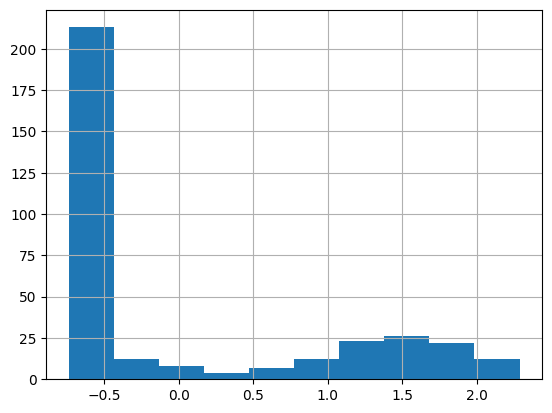

In [148]:
((df["Dogleg"]-df["Dogleg"].mean()) / df["Dogleg"].std()).hist()

In [149]:
df_dict = collections.defaultdict(list)
df_dict_val = collections.defaultdict(list)
df_target_cols = {}
df_target_cols_val = {}
train_folders = ['moldabek2737', "aktobe120","gran78"]
val_folders = ["balgimbayev245"]
types = [
    "ves_na_kru", 
    "effect_na", 
    "moment", 
    "min_ves"
]

print("--- TRAIN ---")
for folder in train_folders:
    print(folder)
    for type_name in types:
        if folder == "gran78" and type_name == "min_ves":
            print(f"\t Skipping {type_name} for {folder}")
            continue
        print("\t", type_name)
        df = pd.read_csv(f"../data/preprocessed/{folder}/{folder}_X.csv")
        y_ves = pd.read_csv(f"../data/preprocessed/{folder}/{folder}_Y_{type_name}.csv")
        
        if type_name == "effect_na":
            y_ves = y_ves.rename({"Глубина по стволу" : "MD"}, axis=1).drop("Глубина по вертикали", axis=1)
            y_ves = y_ves.drop_duplicates(subset='MD', keep='first')
        else:
            y_ves = y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1)
        
        # Remove commas and convert to float if needed
        if y_ves["MD"].dtype == object:
            y_ves["MD"] = y_ves["MD"].str.replace(',', '').astype('float64')
        else:
            y_ves["MD"] = y_ves["MD"].astype('float64')
        
        target_cols = list(set(y_ves.columns) - set(["MD"]))

        merge_ves = pd.merge_asof(df, y_ves, on="MD")
        df_dict[type_name].append(merge_ves)
        df_target_cols[type_name] = target_cols

print("\n\n--- VALIDATION ---")

for folder in val_folders:
    print(folder)
    for type_name in types:
        print("\t", type_name)
        df = pd.read_csv(f"../data/preprocessed/{folder}/{folder}_X.csv")
        y_ves = pd.read_csv(f"../data/preprocessed/{folder}/{folder}_Y_{type_name}.csv")
        
        if type_name == "effect_na":
            y_ves = y_ves.rename({"Глубина по стволу" : "MD"}, axis=1).drop("Глубина по вертикали", axis=1)
            y_ves = y_ves.drop_duplicates(subset='MD', keep='first')
        else:
            y_ves = y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1)
                
        target_cols = list(set(y_ves.columns) - set(["MD"]))
        merge_ves = pd.merge_asof(df, y_ves, on="MD")
        df_dict_val[type_name].append(merge_ves)
        df_target_cols_val[type_name] = target_cols


--- TRAIN ---
moldabek2737
	 ves_na_kru
	 effect_na
	 moment
	 min_ves
aktobe120
	 ves_na_kru
	 effect_na
	 moment
	 min_ves
gran78
	 ves_na_kru
	 effect_na
	 moment
	 Skipping min_ves for gran78


--- VALIDATION ---
balgimbayev245
	 ves_na_kru
	 effect_na
	 moment
	 min_ves


In [150]:
df_dict

defaultdict(list,
            {'ves_na_kru': [         MD   Incl.  Azim.  Sub-Sea      TVD  Local N Coord  Local E Coord  \
              0     0.000   0.000  0.000  -76.517    0.000          0.000          0.000   
              1    40.000   0.000  0.000  -36.517   40.000          0.000          0.000   
              2    50.000   0.833  0.349  -26.517   50.000          0.073          0.000   
              3    60.000   1.667  0.349  -16.520   59.997          0.291          0.002   
              4    70.000   2.500  0.349   -6.526   69.990          0.654          0.004   
              ..      ...     ...    ...      ...      ...            ...            ...   
              75  730.000  90.000  0.850  276.483  353.000        480.782          5.859   
              76  740.000  90.000  0.850  276.483  353.000        490.781          6.007   
              77  750.000  90.000  0.850  276.483  353.000        500.780          6.156   
              78  760.000  90.000  0.850  276.48

In [151]:
pd.concat(df_dict["min_ves"])[df_target_cols["min_ves"]]

,Мин. вес на долоте до спирального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до синусоидального изгиба (бурение ротором),Мин. вес на долоте до спирального изгиба (бурение ГЗД)
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
334,12.32,3.17,11.56,4.11
335,12.32,3.17,11.56,4.11
336,10.94,2.06,10.66,2.89
337,10.94,2.06,10.66,2.89


In [152]:
concanted_df = {}
for type_name in types:
    # Concatenate DataFrames
    temp = pd.concat(df_dict[type_name])
    
    # Sort the concatenated DataFrame by "MD"
    temp = temp.sort_values("MD")
    
    # Drop rows with missing values in the target columns
    temp = temp.dropna(subset=df_target_cols[type_name])
    
    # Store the cleaned DataFrame
    concanted_df[type_name] = temp


In [153]:
concanted_df

{'ves_na_kru':            MD   Incl.  Azim.   Sub-Sea       TVD  Local N Coord  \
 29    300.000  44.737   0.35   206.366   282.883         71.197   
 30    304.738  46.000   0.35   209.695   286.211         74.568   
 31    310.000  46.263   0.35   213.341   289.858         78.362   
 32    320.000  46.763   0.35   220.223   296.740         85.617   
 33    324.738  47.000   0.35   223.461   299.978         89.075   
 ..        ...     ...    ...       ...       ...            ...   
 334  2890.000  90.000  20.11  2243.739  2226.371        763.522   
 335  2900.000  90.000  20.11  2243.739  2226.371        772.912   
 336  2910.000  90.000  20.11  2243.739  2226.371        782.302   
 337  2920.000  90.000  20.11  2243.739  2226.371        791.693   
 338  2927.227  90.000  20.11  2243.739  2226.371        798.479   
 
      Local E Coord  Global N Coord  Global E Coord  Dogleg  ...  Weight  \
 29           0.434     5291133.987    1.028502e+07     8.0  ...   25.12   
 30           0.

In [154]:
concanted_df["effect_na"]["Грузоподъёмность вышки"].isna().sum()

0

In [155]:
concanted_df['min_ves'].columns

Index(['MD', 'Incl.', 'Azim.', 'Sub-Sea', 'TVD', 'Local N Coord',
       'Local E Coord', 'Global N Coord', 'Global E Coord', 'Dogleg',
       'Vertical Section', 'Body_OD', 'Body_ID', 'Body_AvgJointLength',
       'Stabilizer_Length', 'Stabilizer_OD', 'Stabilizer_ID', 'Weight',
       'Coefficient of Friction', 'Minimum Yield Stress',
       'Мин. вес на долоте до синусоидального изгиба (бурение ротором)',
       'Мин. вес на долоте до спирального изгиба (бурение ротором)',
       'Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)',
       'Мин. вес на долоте до спирального изгиба (бурение ГЗД)'],
      dtype='object')

In [156]:
df_dict["effect_na"][1]["Грузоподъёмность вышки"].isna().sum()

0

In [157]:
df_dict

defaultdict(list,
            {'ves_na_kru': [         MD   Incl.  Azim.  Sub-Sea      TVD  Local N Coord  Local E Coord  \
              0     0.000   0.000  0.000  -76.517    0.000          0.000          0.000   
              1    40.000   0.000  0.000  -36.517   40.000          0.000          0.000   
              2    50.000   0.833  0.349  -26.517   50.000          0.073          0.000   
              3    60.000   1.667  0.349  -16.520   59.997          0.291          0.002   
              4    70.000   2.500  0.349   -6.526   69.990          0.654          0.004   
              ..      ...     ...    ...      ...      ...            ...            ...   
              75  730.000  90.000  0.850  276.483  353.000        480.782          5.859   
              76  740.000  90.000  0.850  276.483  353.000        490.781          6.007   
              77  750.000  90.000  0.850  276.483  353.000        500.780          6.156   
              78  760.000  90.000  0.850  276.48

In [158]:
concanted_df

{'ves_na_kru':            MD   Incl.  Azim.   Sub-Sea       TVD  Local N Coord  \
 29    300.000  44.737   0.35   206.366   282.883         71.197   
 30    304.738  46.000   0.35   209.695   286.211         74.568   
 31    310.000  46.263   0.35   213.341   289.858         78.362   
 32    320.000  46.763   0.35   220.223   296.740         85.617   
 33    324.738  47.000   0.35   223.461   299.978         89.075   
 ..        ...     ...    ...       ...       ...            ...   
 334  2890.000  90.000  20.11  2243.739  2226.371        763.522   
 335  2900.000  90.000  20.11  2243.739  2226.371        772.912   
 336  2910.000  90.000  20.11  2243.739  2226.371        782.302   
 337  2920.000  90.000  20.11  2243.739  2226.371        791.693   
 338  2927.227  90.000  20.11  2243.739  2226.371        798.479   
 
      Local E Coord  Global N Coord  Global E Coord  Dogleg  ...  Weight  \
 29           0.434     5291133.987    1.028502e+07     8.0  ...   25.12   
 30           0.

<Axes: >

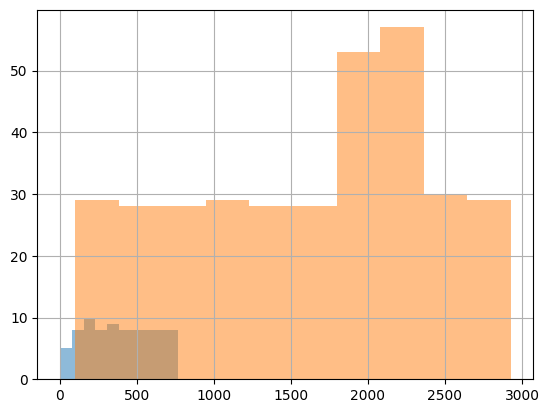

In [159]:
df_dict[type_name][0]["MD"].hist(alpha=.5)
df_dict[type_name][1]["MD"].hist(alpha=.5)
# df_dict_val[type_name][0]["MD"].hist(alpha=.5)

In [160]:
types

['ves_na_kru', 'effect_na', 'moment', 'min_ves']

In [161]:
df_target_cols

{'ves_na_kru': ['Грузоподъёмность вышки',
  'Бурение ротором',
  'Подъём',
  'Спуск',
  'Бурение ГЗД',
  'Мин. вес до спирального изгиба (спуск)',
  'Макс. вес до предела текучести (подъём)'],
 'effect_na': ['Грузоподъёмность вышки',
  'Бурение ротором',
  'Спиральный изгиб(без вращения)',
  'Подъём',
  'Синусоидальный изгиб(все операции)',
  'Спуск',
  'Бурение ГЗД',
  'Спиральный изгиб(с вращением)',
  'Предел натяжения'],
 'moment': ['Бурение ротором',
  'Подъём',
  ' Make-up Torque',
  'Спуск',
  'Момент свинчивания'],
 'min_ves': ['Мин. вес на долоте до спирального изгиба (бурение ротором)',
  'Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)',
  'Мин. вес на долоте до синусоидального изгиба (бурение ротором)',
  'Мин. вес на долоте до спирального изгиба (бурение ГЗД)']}

## `Multilayer Perceptron + XGBoost Regressor`

In [162]:
class MultiOutputStackingRegressor(BaseEstimator):
    def __init__(self, nn_epochs=4, nn_batch_size=32):
        self.nn_epochs = nn_epochs
        self.nn_batch_size = nn_batch_size
        self.nn_model = None
        self.xgb_model = None
    
    def fit(self, X, y):
        # Step 1: Split data into folds for cross-validation
        kf = KFold(n_splits=3, shuffle=False)
        xgb_inputs = []
        xgb_targets = []
        
        # Step 2: Train Keras neural network and collect predictions
        nn_preds = np.empty_like(y)
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # Train Keras neural network
            nn_model = self._train_keras_nn(X_train, y_train)
            
            # Predict using Keras neural network
            nn_pred = nn_model.predict(X_val)
            nn_preds[val_index] = nn_pred
            
            # Collect inputs and targets for XGBoost training
            xgb_inputs.append(np.concatenate((X_val, nn_pred), axis=1))
            xgb_targets.append(y_val)
        
        # Step 3: Train XGBoost regressor on combined dataset
        combined_xgb_input = np.concatenate(xgb_inputs)
        combined_xgb_target = np.concatenate(xgb_targets)
        self.xgb_model = self._train_xgboost(combined_xgb_input, combined_xgb_target)
        
        # Step 4: Train neural network on entire dataset
        self.nn_model = self._train_keras_nn(X, y)
    
    def predict(self, X):
        # Step 1: Predict using neural network
        nn_preds = self.nn_model.predict(X)
        
        # Step 2: Combine predictions with original input dataset
        xgb_input = np.concatenate((X, nn_preds), axis=1)

        # Step 3: Predict using XGBoost regressor
        return self.xgb_model.predict(xgb_input)
    
    def _train_keras_nn(self, X, y):
        input_shape = X.shape[1]
        output_shape = y.shape[1]
        
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Dense(64, input_shape=(input_shape,), activation="relu", kernel_regularizer='l1', bias_regularizer='l1'))
        model.add(Dense(48, activation='relu', kernel_regularizer='l1', bias_regularizer='l1'))
        model.add(Dense(output_shape, activation=None))  # No activation for regression
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss=keras.losses.Huber()
        )
        
        model.fit(X, y, epochs=self.nn_epochs, batch_size=self.nn_batch_size, verbose=0, shuffle=False)
        return model
    
    def _train_xgboost(self, X, y):
        xgb = XGBRegressor(n_estimators=100, 
                       colsample_bytree=0.5,
                       max_depth=5,
                       tree_method="hist",
                       subsample=1.0,
                       reg_lambda=1e-03,
                       min_child_weight=3,
                       multi_strategy="multi_output_tree")
        # xgb = MultiOutputRegressor(LGBMRegressor(verbose=-1, subsample=0.7, subsample_freq=2))
        xgb.fit(X, y)
        return xgb


In [163]:
df_dict_val_new = {}
for type_name in types:
    # Concatenate DataFrames
    temp = pd.concat(df_dict_val[type_name])
    
    # Drop rows with missing values in the target columns
    temp = temp.dropna(subset=df_target_cols[type_name])
    
    # Store the cleaned DataFrame
    df_dict_val_new[type_name] = temp


In [165]:
# Combine concanted_df and df_dict_val_new into one dataframe
df_combined = {}
for type_name in types:
    df_combined[type_name] = pd.concat([concanted_df[type_name], df_dict_val_new[type_name]], ignore_index=True)

In [166]:
df_combined['ves_na_kru'].rename(columns = {'Local N Coord':'Local_N_Coord', 'Local E Coord':'Local_E_Coord', 
                                            'Global N Coord':'Global_N_Coord', 'Global E Coord':'Global_E_Coord',
                                            'Incl.':'Incl',
                                            'Vertical Section':'Vertical_Section',
                                            'Azim.':'Azim',
                                            'Sub-Sea':'Sub_Sea',
                                            'Coefficient of Friction':'Coefficient_of_Friction',
                                            'Minimum Yield Stress':'Minimum_Yield_Stress'
                                            }, 
                                            inplace = True)
df_combined['effect_na'].rename(columns = {'Local N Coord':'Local_N_Coord', 'Local E Coord':'Local_E_Coord', 
                                            'Global N Coord':'Global_N_Coord', 'Global E Coord':'Global_E_Coord',
                                            'Incl.':'Incl',
                                            'Vertical Section':'Vertical_Section',
                                            'Azim.':'Azim',
                                            'Sub-Sea':'Sub_Sea',
                                            'Coefficient of Friction':'Coefficient_of_Friction',
                                            'Minimum Yield Stress':'Minimum_Yield_Stress'
                                            }, 
                                            inplace = True)
df_combined['min_ves'].rename(columns = {'Local N Coord':'Local_N_Coord', 'Local E Coord':'Local_E_Coord', 
                                            'Global N Coord':'Global_N_Coord', 'Global E Coord':'Global_E_Coord',
                                            'Incl.':'Incl',
                                            'Vertical Section':'Vertical_Section',
                                            'Azim.':'Azim',
                                            'Sub-Sea':'Sub_Sea',
                                            'Coefficient of Friction':'Coefficient_of_Friction',
                                            'Minimum Yield Stress':'Minimum_Yield_Stress'
                                            }, 
                                            inplace = True)
df_combined['moment'].rename(columns = {'Local N Coord':'Local_N_Coord', 'Local E Coord':'Local_E_Coord', 
                                            'Global N Coord':'Global_N_Coord', 'Global E Coord':'Global_E_Coord',
                                            'Incl.':'Incl',
                                            'Vertical Section':'Vertical_Section',
                                            'Azim.':'Azim',
                                            'Sub-Sea':'Sub_Sea',
                                            'Coefficient of Friction':'Coefficient_of_Friction',
                                            'Minimum Yield Stress':'Minimum_Yield_Stress'
                                            }, 
                                            inplace = True)


In [167]:
df_combined

{'ves_na_kru':            MD    Incl    Azim  Sub_Sea      TVD  Local_N_Coord  Local_E_Coord  \
 0     300.000  44.737    0.35  206.366  282.883         71.197          0.434   
 1     304.738  46.000    0.35  209.695  286.211         74.568          0.455   
 2     310.000  46.263    0.35  213.341  289.858         78.362          0.478   
 3     320.000  46.763    0.35  220.223  296.740         85.617          0.522   
 4     324.738  47.000    0.35  223.461  299.978         89.075          0.544   
 ..        ...     ...     ...      ...      ...            ...            ...   
 229  1170.000  90.000  248.00  681.280  659.520       -241.478       -597.678   
 230  1200.000  90.000  248.00  681.280  659.520       -252.716       -625.493   
 231  1230.000  90.000  248.00  681.280  659.520       -263.954       -653.309   
 232  1260.000  90.000  248.00  681.280  659.520       -275.192       -681.124   
 233  1281.059  90.000  248.00  681.280  659.520       -283.081       -700.650   
 


In [168]:
# Define the function to process a given type and return the WMAPE dataframe
def calculate_wmape(current_type):
    # Extract the relevant data from the dataframe
    X = df_combined[current_type]
    x_target_cols = df_target_cols[current_type]
    if current_type == 'effect_na':
        X = X[X['Бурение ГЗД'] <= 10]
        X = X[X['Предел натяжения'] <= 200]
        
    # Separate the target columns
    y = X[x_target_cols]
    X = X.drop(x_target_cols, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Feature engineering function
    def add_features(df):
        df["sin_Incl."] = np.sin(df["Incl"])
        df["cos_Incl."] = np.cos(df["Incl"])
        df["tan_Incl."] = np.tan(df["Incl"])
        
        df["sin_Azim."] = np.sin(df["Azim"])
        df["cos_Azim."] = np.cos(df["Azim"])
        df["tan_Azim."] = np.tan(df["Azim"])
        
        df["Local_polar_angle"] = np.arctan2(df["Local_N_Coord"], df["Local_E_Coord"])
        df["Local_polar_r"] = np.sqrt(df["Local_N_Coord"]**2 + df["Local_E_Coord"]**2)
        
        df["Global_polar_angle"] = np.arctan2(df["Global_N_Coord"], df["Global_E_Coord"])
        df["Global_polar_r"] = np.sqrt(df["Global_N_Coord"]**2 + df["Global_E_Coord"]**2)
        return df

    # Apply feature engineering to both training and test data
    X_train = add_features(X_train)
    X_test = add_features(X_test)

    # Initialize scalers for feature scaling
    x_scaler, y_scaler = StandardScaler(), StandardScaler()

    # Scale the training data
    X_train_scaled = x_scaler.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(y_train)

    # Scale the test data
    X_test_scaled = x_scaler.transform(X_test)
    y_test_scaled = y_scaler.transform(y_test)

    # Define and train the model
    model = MultiOutputStackingRegressor()
    model.fit(X_train_scaled, y_train_scaled)

    # Save the neural network model separately using Keras' save method
    nn_model_name = f'nn_model_{current_type}.h5'
    model.nn_model.save(nn_model_name)

    # Save the XGBoost model using joblib
    xgb_model_name = f'xgb_model_{current_type}.pkl'
    joblib.dump(model.xgb_model, xgb_model_name)

    # Save the scalers using joblib
    x_scaler_name = f'x_scaler_{current_type}.pkl'
    y_scaler_name = f'y_scaler_{current_type}.pkl'
    joblib.dump(x_scaler, x_scaler_name)
    joblib.dump(y_scaler, y_scaler_name)

    print(f"Models and scalers for type '{current_type}' have been saved separately.")

      
    # Make predictions and calculate WMAPE
    predictions = pd.DataFrame(y_scaler.inverse_transform(model.predict(X_test_scaled)), columns=y.columns)
    diff = predictions - y_test.reset_index(drop=True)
    wmape = abs(diff).sum() / np.where(y_test.reset_index(drop=True).sum().abs() == 0, 1, y_test.reset_index(drop=True).sum().abs())
    
    # Add the current type to the WMAPE dataframe
    wmape_df = wmape.reset_index().rename(columns={0: 'wmape'})
    wmape_df['type'] = current_type

    return wmape_df


# Initialize an empty list to store WMAPE dataframes
wmape_dfs = []

# Traverse through types and calculate WMAPE for each type
for current_type in types:
    wmape_df = calculate_wmape(current_type)
    wmape_dfs.append(wmape_df)

# Concatenate all WMAPE dataframes
concatenated_wmape_df = pd.concat(wmape_dfs, ignore_index=True)

# Export the concatenated dataframe to a CSV file
concatenated_wmape_df.to_csv('wmape_summary.csv', index=False)

print("WMAPE summary has been exported to 'wmape_summary.csv'.")


/opt/anaconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Models and scalers for type 'ves_na_kru' have been saved separately.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/opt/anaconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Models and scalers for type 'effect_na' have been saved separately.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/opt/anaconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Models and scalers for type 'moment' have been saved separately.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/opt/anaconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Models and scalers for type 'min_ves' have been saved separately.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
WMAPE summary has been exported to 'wmape_summary.csv'.


In [169]:
concatenated_wmape_df

,index,wmape,type
0,Грузоподъёмность вышки,0.000000,ves_na_kru
1,Бурение ротором,0.005964,ves_na_kru
2,Подъём,0.004207,ves_na_kru
3,Спуск,0.014113,ves_na_kru
4,Бурение ГЗД,0.015880,ves_na_kru
5,Мин. вес до спирального изгиба (спуск),0.012408,ves_na_kru
6,Макс. вес до предела текучести (подъём),0.008219,ves_na_kru
7,Грузоподъёмность вышки,0.000000,effect_na
8,Бурение ротором,0.101938,effect_na
9,Спиральный изгиб(без вращения),0.151081,effect_na


In [170]:
concatenated_wmape_df['wmape%'] = concatenated_wmape_df['wmape'].apply(lambda x: '{:.2f}%'.format(x * 100))

In [171]:
concatenated_wmape_df

,index,wmape,type,wmape%
0,Грузоподъёмность вышки,0.000000,ves_na_kru,0.00%
1,Бурение ротором,0.005964,ves_na_kru,0.60%
2,Подъём,0.004207,ves_na_kru,0.42%
3,Спуск,0.014113,ves_na_kru,1.41%
4,Бурение ГЗД,0.015880,ves_na_kru,1.59%
5,Мин. вес до спирального изгиба (спуск),0.012408,ves_na_kru,1.24%
6,Макс. вес до предела текучести (подъём),0.008219,ves_na_kru,0.82%
7,Грузоподъёмность вышки,0.000000,effect_na,0.00%
8,Бурение ротором,0.101938,effect_na,10.19%
9,Спиральный изгиб(без вращения),0.151081,effect_na,15.11%


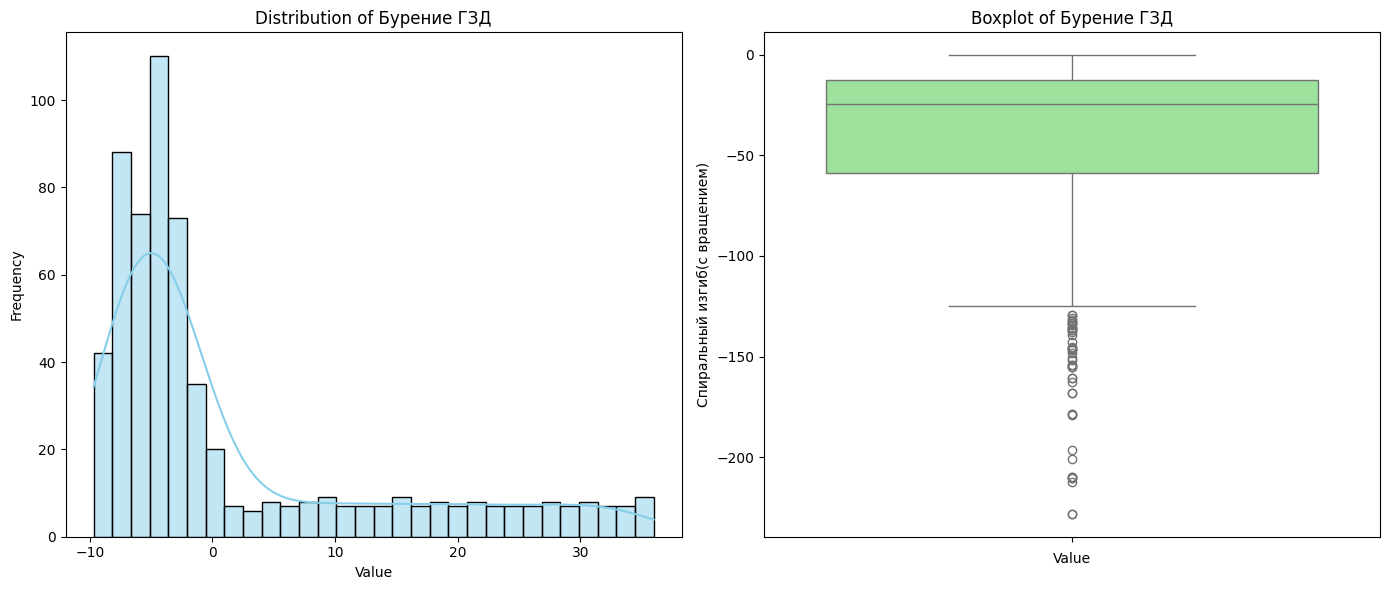

In [172]:
# Plotting the histogram and boxplot
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(data = df_combined['effect_na']['Бурение ГЗД'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Бурение ГЗД')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data = df_combined['effect_na']['Спиральный изгиб(с вращением)'], color='lightgreen')
plt.title('Boxplot of Бурение ГЗД')
plt.xlabel('Value')

plt.tight_layout()
plt.show()

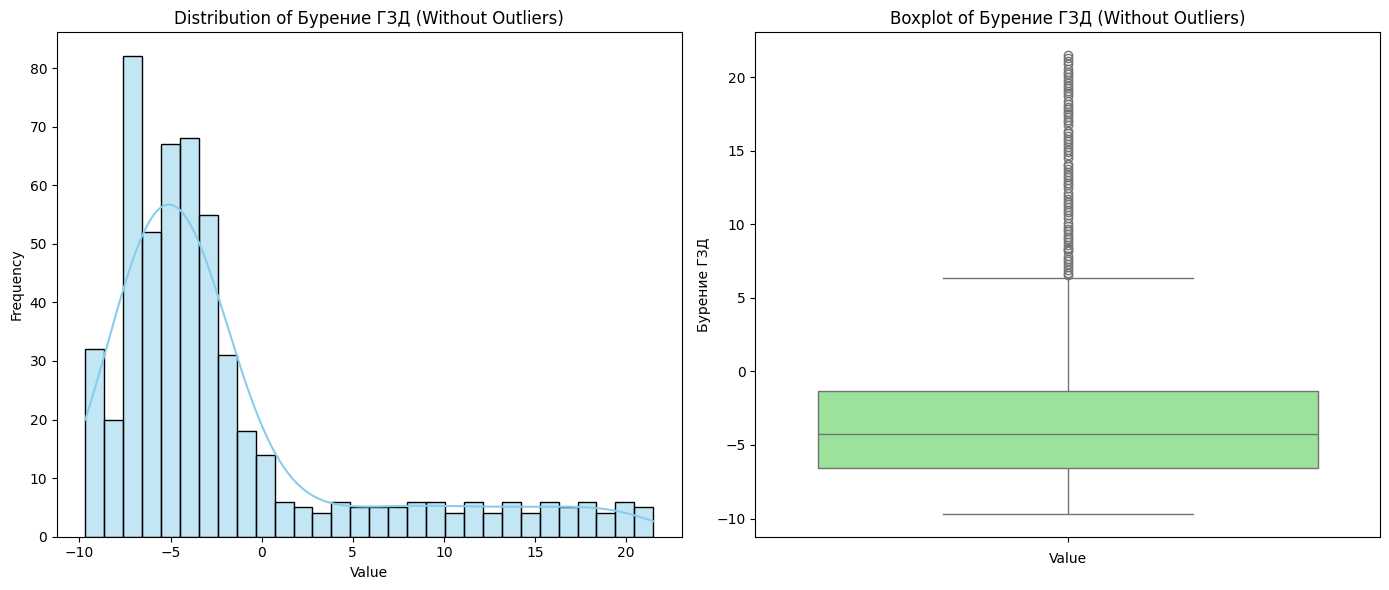

In [173]:
# Removing outliers using the IQR method
Q1 = df_combined['effect_na']['Бурение ГЗД'].quantile(0.25)
Q3 = df_combined['effect_na']['Бурение ГЗД'].quantile(0.75)
IQR = Q3 - Q1

# Filtering out outliers
data_filtered = df_combined['effect_na']['Бурение ГЗД'][(df_combined['effect_na']['Бурение ГЗД'] >= (Q1 - 1.5 * IQR)) & (df_combined['effect_na']['Бурение ГЗД'] <= (Q3 + 1.5 * IQR))]

# Plotting the distribution and boxplot after removing outliers
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(data_filtered, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Бурение ГЗД (Without Outliers)')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data_filtered, color='lightgreen')
plt.title('Boxplot of Бурение ГЗД (Without Outliers)')
plt.xlabel('Value')

plt.tight_layout()
plt.show()


# `Visualizations`

In [5]:
# Feature engineering function
def add_features(df):
    df["sin_Incl."] = np.sin(df["Incl"])
    df["cos_Incl."] = np.cos(df["Incl"])
    df["tan_Incl."] = np.tan(df["Incl"])
        
    df["sin_Azim."] = np.sin(df["Azim"])
    df["cos_Azim."] = np.cos(df["Azim"])
    df["tan_Azim."] = np.tan(df["Azim"])
        
    df["Local_polar_angle"] = np.arctan2(df["Local_N_Coord"], df["Local_E_Coord"])
    df["Local_polar_r"] = np.sqrt(df["Local_N_Coord"]**2 + df["Local_E_Coord"]**2)
        
    df["Global_polar_angle"] = np.arctan2(df["Global_N_Coord"], df["Global_E_Coord"])
    df["Global_polar_r"] = np.sqrt(df["Global_N_Coord"]**2 + df["Global_E_Coord"]**2)
    return df

In [6]:
X = pd.read_csv("../data/preprocessed/aktobe120/aktobe120_X.csv")
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MD                       339 non-null    float64
 1   Incl.                    339 non-null    float64
 2   Azim.                    339 non-null    float64
 3   Sub-Sea                  339 non-null    float64
 4   TVD                      339 non-null    float64
 5   Local N Coord            339 non-null    float64
 6   Local E Coord            339 non-null    float64
 7   Global N Coord           339 non-null    float64
 8   Global E Coord           339 non-null    float64
 9   Dogleg                   339 non-null    float64
 10  Vertical Section         339 non-null    float64
 11  Body_OD                  339 non-null    float64
 12  Body_ID                  339 non-null    float64
 13  Body_AvgJointLength      339 non-null    float64
 14  Stabilizer_Length        3

## `Вес на крюке`

In [7]:
Y_ves = pd.read_csv("../data/preprocessed/aktobe120/aktobe120_Y_ves_na_kru.csv")
Y_ves = Y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1)
# Y_ves["MD"] = Y_ves["MD"].str.replace(",", "").astype(float)
Y_ves.head(5)

,MD,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Грузоподъёмность вышки
0,2359,59.80,71.92,59.40,57.01,52.06,132.07,225
1,2409,59.19,72.11,59.23,56.10,54.22,131.98,225
2,2459,58.40,72.72,59.14,55.26,53.84,132.81,225
3,2509,58.14,72.85,59.13,54.93,53.56,132.74,225
4,2559,58.86,74.26,60.09,55.76,53.61,132.29,225


In [8]:
target_cols = list(set(Y_ves.columns) - set(["MD"]))
Y_ves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   MD                                       13 non-null     int64  
 1   Спуск                                    13 non-null     float64
 2   Подъём                                   13 non-null     float64
 3   Бурение ротором                          13 non-null     float64
 4   Бурение ГЗД                              13 non-null     float64
 5   Мин. вес до спирального изгиба (спуск)   13 non-null     float64
 6   Макс. вес до предела текучести (подъём)  13 non-null     float64
 7   Грузоподъёмность вышки                   13 non-null     int64  
dtypes: float64(6), int64(2)
memory usage: 960.0 bytes


In [9]:
X_ves = X[(X["MD"] >= Y_ves["MD"].min()) & (X["MD"] <= Y_ves["MD"].max())]
X_ves.head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
279,2360.0,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,282.94,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
280,2370.0,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,292.79,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
281,2380.0,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,302.67,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
282,2390.0,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,312.60,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
283,2400.0,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,322.55,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105


In [10]:
X_ves.rename(columns = {'Local N Coord':'Local_N_Coord', 'Local E Coord':'Local_E_Coord', 
                                            'Global N Coord':'Global_N_Coord', 'Global E Coord':'Global_E_Coord',
                                            'Incl.':'Incl',
                                            'Vertical Section':'Vertical_Section',
                                            'Azim.':'Azim',
                                            'Sub-Sea':'Sub_Sea',
                                            'Coefficient of Friction':'Coefficient_of_Friction',
                                            'Minimum Yield Stress':'Minimum_Yield_Stress'
                                            }, 
                                            inplace = True)

/var/folders/rt/ht2w66yn71737qv5l2n9w4s00000gn/T/ipykernel_3699/1563055712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ves.rename(columns = {'Local N Coord':'Local_N_Coord', 'Local E Coord':'Local_E_Coord',


In [11]:
X_ves["MD"] = X_ves["MD"].astype(int)
Y_ves["MD"] = Y_ves["MD"].astype(int)
df = pd.merge_asof(X_ves, Y_ves, on="MD", direction="nearest")
df.head()

/var/folders/rt/ht2w66yn71737qv5l2n9w4s00000gn/T/ipykernel_3699/1022974934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ves["MD"] = X_ves["MD"].astype(int)


,MD,Incl,Azim,Sub_Sea,TVD,Local_N_Coord,Local_E_Coord,Global_N_Coord,Global_E_Coord,Dogleg,...,Weight,Coefficient_of_Friction,Minimum_Yield_Stress,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Грузоподъёмность вышки
0,2360,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,...,25.12,0.3,105,59.80,71.92,59.40,57.01,52.06,132.07,225
1,2370,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,...,25.12,0.3,105,59.80,71.92,59.40,57.01,52.06,132.07,225
2,2380,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,...,25.12,0.3,105,59.80,71.92,59.40,57.01,52.06,132.07,225
3,2390,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,...,25.12,0.3,105,59.19,72.11,59.23,56.10,54.22,131.98,225
4,2400,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,...,25.12,0.3,105,59.19,72.11,59.23,56.10,54.22,131.98,225


In [12]:
y_full = df[target_cols]
X_full = df.drop(target_cols, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size=.5,shuffle=False)
X_train.shape, X_test.shape

((30, 20), (30, 20))

In [13]:
# Apply feature engineering to both training and test data
X_test = add_features(X_test)

# Load the Keras neural network model
nn_model = tf.keras.models.load_model(f'nn_model_ves_na_kru.h5')

# Load the XGBoost model
xgb_model = joblib.load(f'xgb_model_ves_na_kru.pkl')

# Load the scalers
x_scaler = joblib.load(f'x_scaler_ves_na_kru.pkl')
y_scaler = joblib.load(f'y_scaler_ves_na_kru.pkl')


# Scale the test data
X_test_scaled = x_scaler.transform(X_test)

# Make predictions using the neural network
nn_predictions = nn_model.predict(X_test_scaled)

# Combine predictions with original input dataset for XGBoost
xgb_input = np.concatenate((X_test_scaled, nn_predictions), axis=1)

# Make predictions using XGBoost
xgb_predictions = xgb_model.predict(xgb_input)

# Inverse transform the predictions to original scale
predictions = pd.DataFrame(y_scaler.inverse_transform(xgb_predictions), columns=y_test.columns)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [14]:
predictions

,Спуск,Бурение ГЗД,Грузоподъёмность вышки,Бурение ротором,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Подъём
0,225.0,60.078644,74.940277,58.186493,55.080273,53.309036,133.163040
1,225.0,60.068874,74.946434,58.170898,55.065887,53.316338,133.148544
2,225.0,59.987286,75.002396,57.873520,54.742081,53.533516,133.095474
3,225.0,59.987286,75.002396,57.873520,54.742081,53.533516,133.095474
4,225.0,59.987286,75.002396,57.873520,54.742081,53.533516,133.095474
5,225.0,59.987286,75.002396,57.873520,54.742081,53.533516,133.095474
6,225.0,59.987286,75.002396,57.873520,54.742081,53.533516,133.095474
7,225.0,59.909748,75.557701,57.277424,54.094318,53.374535,132.973236
8,225.0,59.909748,75.557701,57.277424,54.094318,53.374535,132.973236
9,225.0,59.909748,75.557701,57.277424,54.094318,53.374535,132.973236


In [15]:
y_test

,Спуск,Бурение ГЗД,Грузоподъёмность вышки,Бурение ротором,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Подъём
30,57.82,54.68,225,59.99,53.59,132.98,75.02
31,57.82,54.68,225,59.99,53.59,132.98,75.02
32,57.82,54.68,225,59.99,53.59,132.98,75.02
33,57.82,54.68,225,59.99,53.59,132.98,75.02
34,57.82,54.68,225,59.99,53.59,132.98,75.02
35,57.21,54.02,225,59.91,53.37,132.90,75.61
36,57.21,54.02,225,59.91,53.37,132.90,75.61
37,57.21,54.02,225,59.91,53.37,132.90,75.61
38,57.21,54.02,225,59.91,53.37,132.90,75.61
39,57.21,54.02,225,59.91,53.37,132.90,75.61


In [16]:
# Make predictions and calculate WMAPE
diff = predictions - y_test.reset_index(drop=True)
wmape = abs(diff).sum() / np.where(y_test.reset_index(drop=True).sum().abs() == 0, 1, y_test.reset_index(drop=True).sum().abs())
    
# Add the current type to the WMAPE dataframe
wmape_df = wmape.reset_index().rename(columns={0: 'wmape'})
wmape_df['type'] = 'ves_na_kru'



In [20]:
predictions

,Спуск,Бурение ГЗД,Грузоподъёмность вышки,Бурение ротором,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Подъём
0,225.0,60.078644,74.940277,58.186493,55.080273,53.309036,133.163040
1,225.0,60.068874,74.946434,58.170898,55.065887,53.316338,133.148544
2,225.0,59.987286,75.002396,57.873520,54.742081,53.533516,133.095474
3,225.0,59.987286,75.002396,57.873520,54.742081,53.533516,133.095474
4,225.0,59.987286,75.002396,57.873520,54.742081,53.533516,133.095474
5,225.0,59.987286,75.002396,57.873520,54.742081,53.533516,133.095474
6,225.0,59.987286,75.002396,57.873520,54.742081,53.533516,133.095474
7,225.0,59.909748,75.557701,57.277424,54.094318,53.374535,132.973236
8,225.0,59.909748,75.557701,57.277424,54.094318,53.374535,132.973236
9,225.0,59.909748,75.557701,57.277424,54.094318,53.374535,132.973236


In [35]:
# Convert to long format
predictions_long = predictions.iloc[0:1].melt(var_name='Variable', value_name='Predictions')

# Drop the index and reset to a Series with the Variable as index
formatted_predictions = predictions_long.set_index('Variable')['Predictions']
# Add the current type to the WMAPE dataframe
formatted_predictions = formatted_predictions.reset_index()
formatted_predictions['type'] = 'ves_na_kru'
# Display the formatted predictions
print(formatted_predictions)

                                  Variable  Predictions        type
0                                    Спуск   225.000000  ves_na_kru
1                              Бурение ГЗД    60.078644  ves_na_kru
2                   Грузоподъёмность вышки    74.940277  ves_na_kru
3                          Бурение ротором    58.186493  ves_na_kru
4   Мин. вес до спирального изгиба (спуск)    55.080273  ves_na_kru
5  Макс. вес до предела текучести (подъём)    53.309036  ves_na_kru
6                                   Подъём   133.163040  ves_na_kru


In [25]:
wmape

Спуск                                      2.988490
Бурение ГЗД                                0.123654
Грузоподъёмность вышки                     0.663113
Бурение ротором                            0.049594
Мин. вес до спирального изгиба (спуск)     0.044072
Макс. вес до предела текучести (подъём)    0.612177
Подъём                                     0.751327
dtype: float64

In [17]:
wmape_df

,index,wmape,type
0,Спуск,2.988490,ves_na_kru
1,Бурение ГЗД,0.123654,ves_na_kru
2,Грузоподъёмность вышки,0.663113,ves_na_kru
3,Бурение ротором,0.049594,ves_na_kru
4,Мин. вес до спирального изгиба (спуск),0.044072,ves_na_kru
5,Макс. вес до предела текучести (подъём),0.612177,ves_na_kru
6,Подъём,0.751327,ves_na_kru


In [ ]:

# Initialize an empty list to store WMAPE dataframes
wmape_dfs = []

# Traverse through types and calculate WMAPE for each type
for current_type in types:
    wmape_df = calculate_wmape(current_type)
    wmape_dfs.append(wmape_df)

# Concatenate all WMAPE dataframes
concatenated_wmape_df = pd.concat(wmape_dfs, ignore_index=True)

# Export the concatenated dataframe to a CSV file
concatenated_wmape_df.to_csv('wmape_summary.csv', index=False)

print("WMAPE summary has been exported to 'wmape_summary.csv'.")

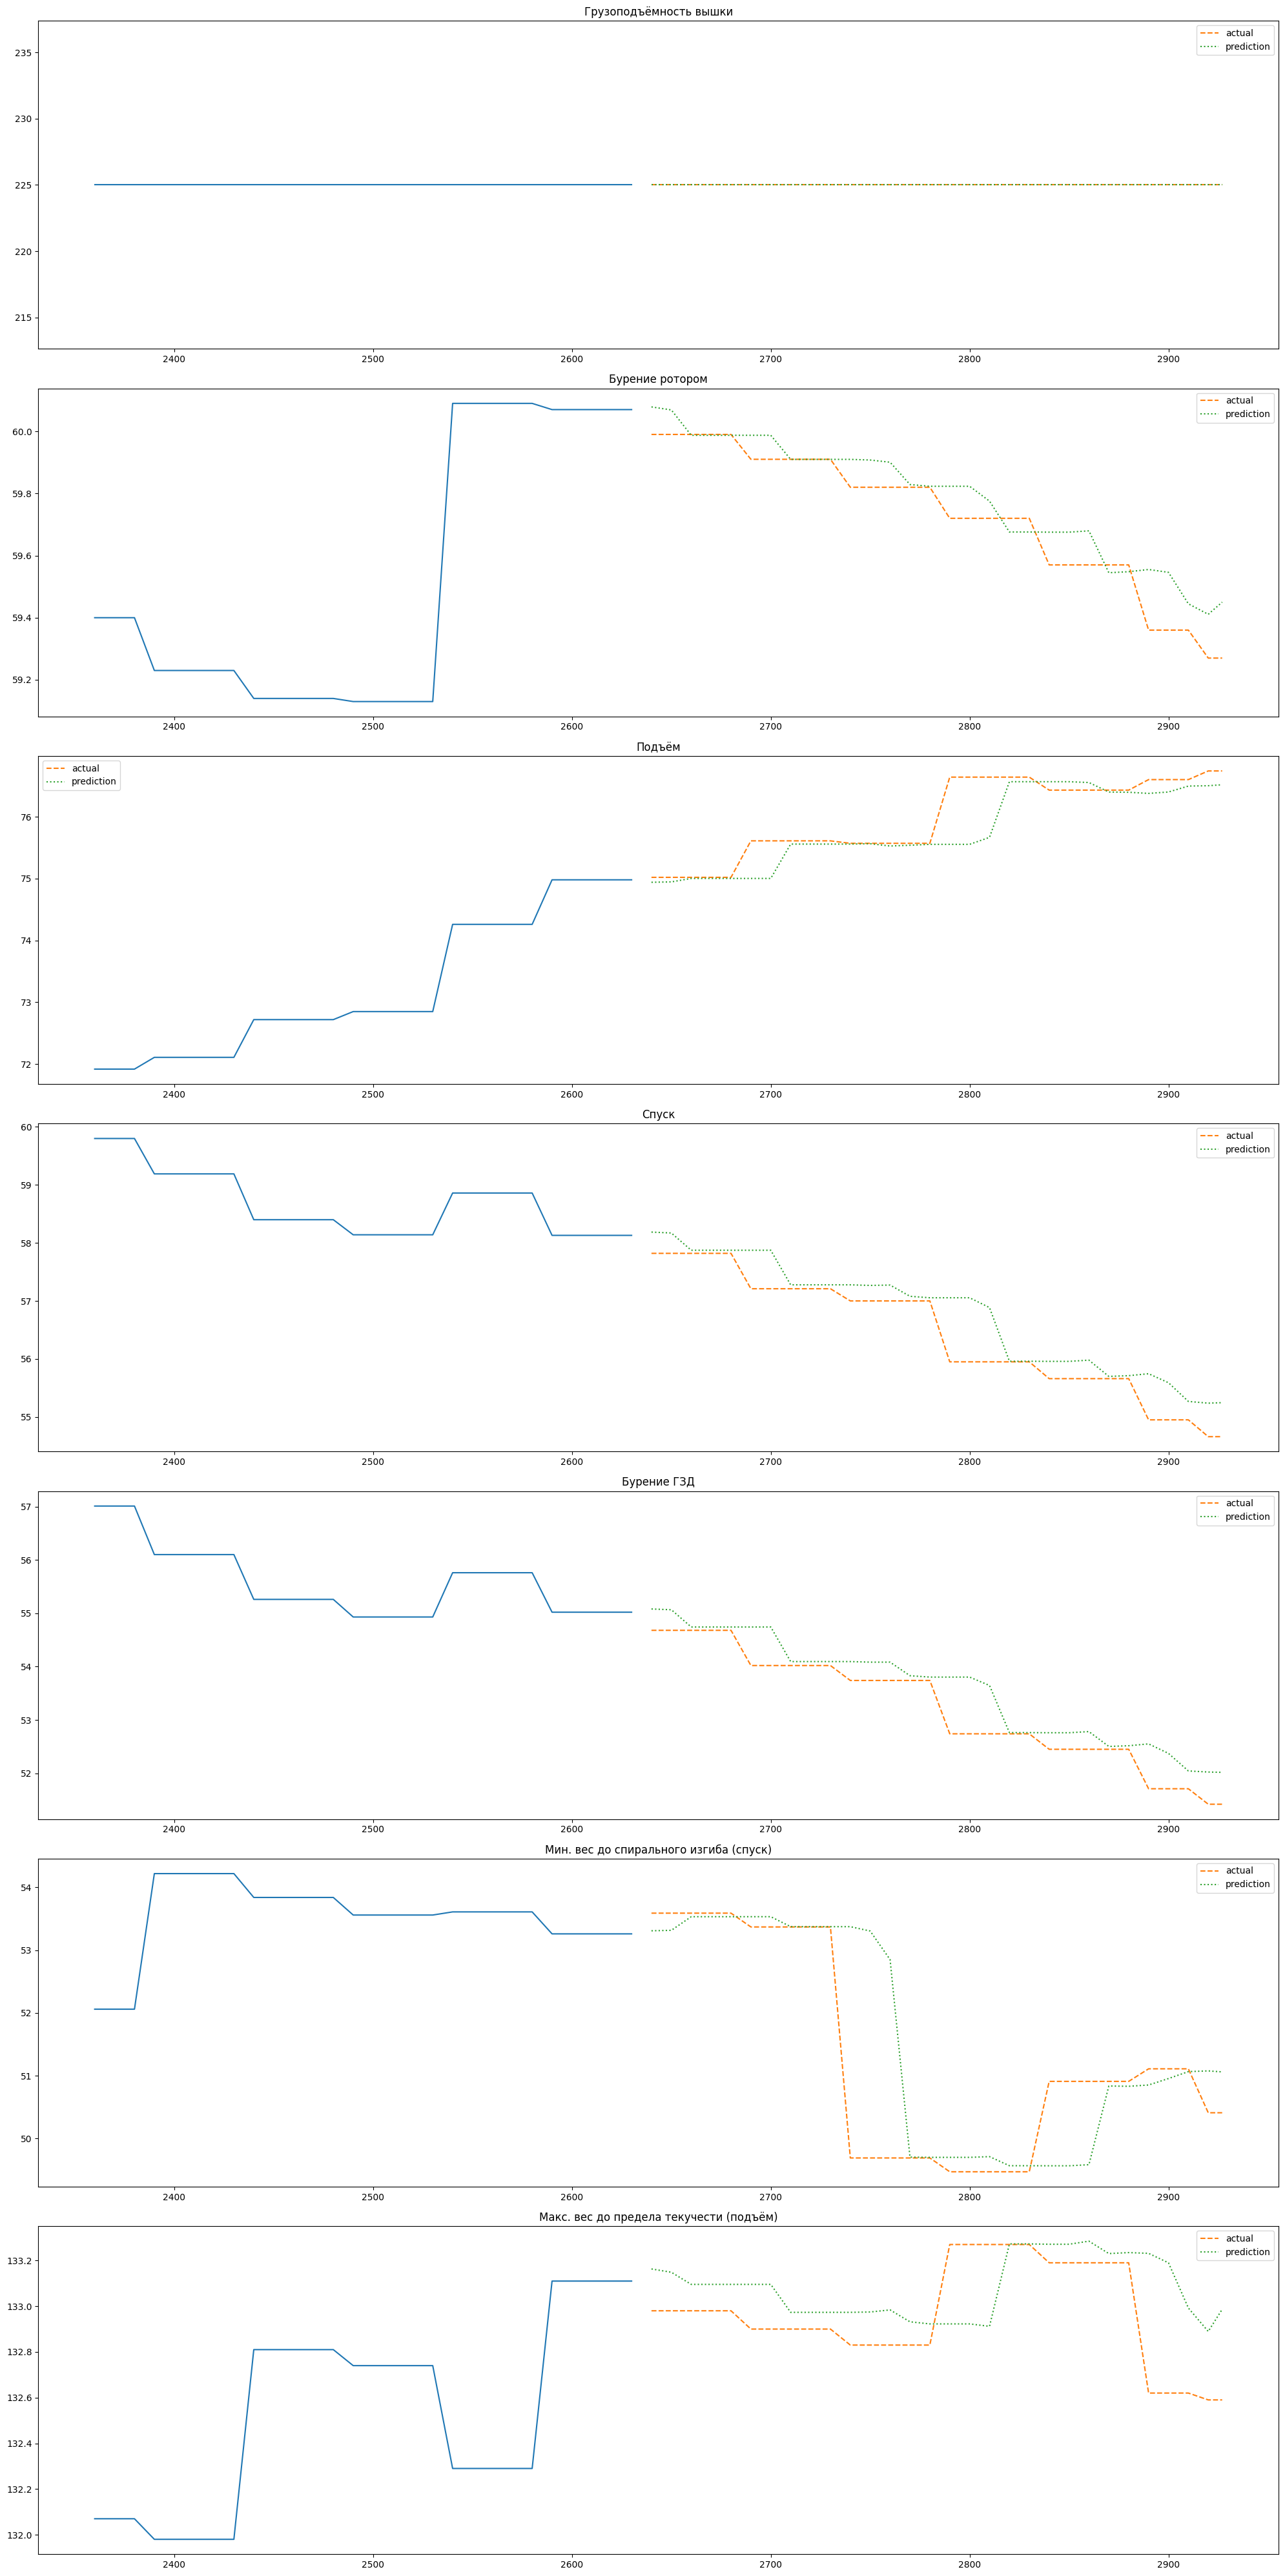

In [338]:
fig, ax = plt.subplots(len(target_cols), figsize=(20, 40))
for i, col in enumerate(target_cols):
    ax[i].set_title(col)
    ax[i].plot(X_train["MD"], y_train[col])
    ax[i].plot(X_test["MD"], y_test[col], label="actual",  linestyle='--')
    ax[i].plot(X_test["MD"], predictions[col], label="prediction", linestyle=':')
    ax[i].legend() 
plt.tight_layout()
plt.show()


In [339]:
y_test = y_test.reset_index().drop("index", axis=1)
mape = (abs(y_test - predictions) / (y_test+1e-8)).mean() * 100

print("MAPE Error in percents per column")
print(mape.to_frame())

MAPE Error in percents per column
                                                0
Грузоподъёмность вышки                   0.000000
Бурение ротором                          0.117738
Подъём                                   0.280923
Спуск                                    0.621352
Бурение ГЗД                              0.695049
Мин. вес до спирального изгиба (спуск)   1.219553
Макс. вес до предела текучести (подъём)  0.140335


['Грузоподъёмность вышки', 'Бурение ротором', 'Подъём', 'Спуск', 'Бурение ГЗД', 'Мин. вес до спирального изгиба (спуск)', 'Макс. вес до предела текучести (подъём)']


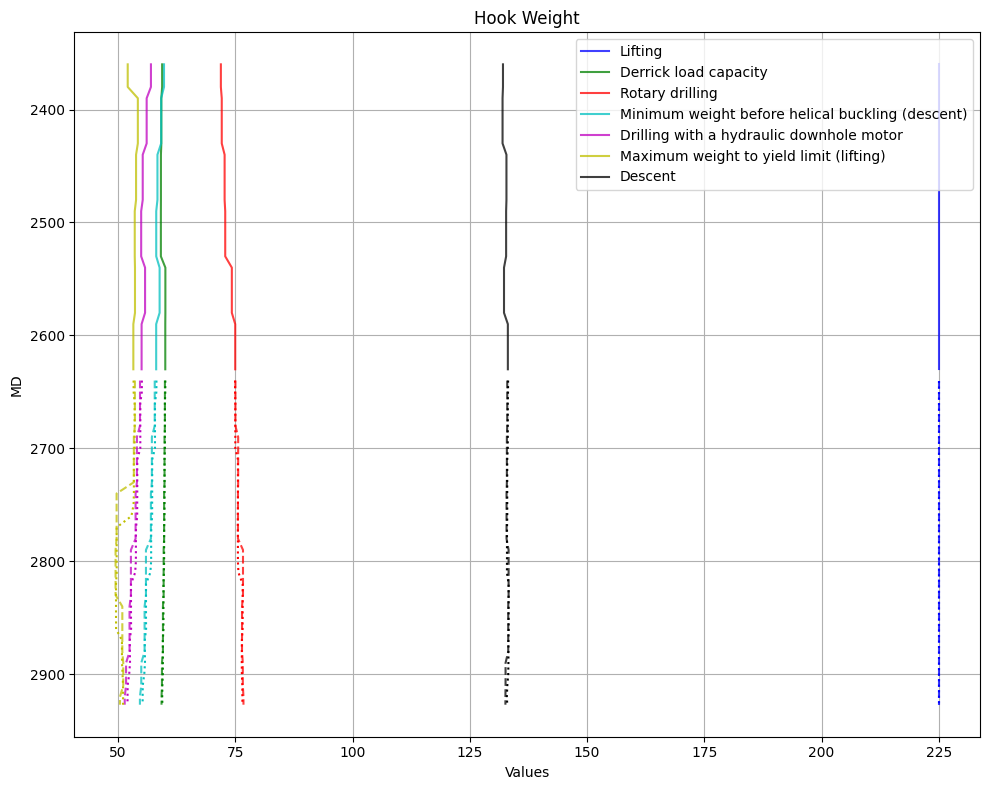

In [340]:
plt.figure(figsize=(10, 8))  # Set the figure size
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500']
target_cols_eng = ['Lifting', 'Derrick load capacity', 'Rotary drilling', 'Minimum weight before helical buckling (descent)', 'Drilling with a hydraulic downhole motor', 'Maximum weight to yield limit (lifting)', 'Descent']

for color, col_id in zip(color_list, range(len(target_cols))):
    col = target_cols[col_id]
    label = target_cols_eng[col_id]
    plt.plot( y_train[col], X_train["MD"], label=label, color=color, alpha=0.75)
    plt.plot( y_test[col],X_test["MD"], color=color, alpha=0.75, linestyle = '--')
    plt.plot( predictions[col],X_test["MD"], color=color, alpha=1.0, linestyle = ':')
# for col, color in zip(df.columns, colors):
#     plt.plot(df.index, df[col], label=col, color=color)
print(target_cols)
# ['Подъём', 'Грузоподъёмность вышки', 'Бурение ротором', 'Мин. вес до спирального изгиба (спуск)', 'Бурение ГЗД', 'Макс. вес до предела текучести (подъём)', 'Спуск']

# Add labels and title
plt.xlabel('Values')
plt.ylabel('MD')
plt.title('Hook Weight')

# Add legend
plt.legend()
plt.gca().invert_yaxis()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


## `Момент`

In [341]:
Y_ves = pd.read_csv("../data/preprocessed/aktobe120/aktobe120_Y_moment.csv")
Y_ves = Y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1)
# Y_ves["MD"] = Y_ves["MD"].str.replace(",", "").astype(float)
Y_ves.head(5)

,MD,Спуск,Подъём,Бурение ротором,Момент свинчивания,Make-up Torque
0,2359,0,0,5.2360,18.3673,18.3673
1,2409,0,0,5.7066,18.3673,18.3673
2,2459,0,0,6.1398,18.3673,18.3673
3,2509,0,0,6.2523,18.3673,18.3673
4,2559,0,0,6.3393,18.3673,18.3673


In [342]:
target_cols = list(set(Y_ves.columns) - set(["MD"]))
Y_ves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MD                  13 non-null     int64  
 1   Спуск               13 non-null     int64  
 2   Подъём              13 non-null     int64  
 3   Бурение ротором     13 non-null     float64
 4   Момент свинчивания  13 non-null     float64
 5    Make-up Torque     13 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 752.0 bytes


In [343]:
X_ves = X[(X["MD"] >= Y_ves["MD"].min()) & (X["MD"] <= Y_ves["MD"].max())]
X_ves.head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
279,2360.0,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,282.94,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
280,2370.0,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,292.79,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
281,2380.0,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,302.67,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
282,2390.0,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,312.60,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
283,2400.0,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,322.55,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105


In [344]:
X_ves.rename(columns = {'Local N Coord':'Local_N_Coord', 'Local E Coord':'Local_E_Coord', 
                                            'Global N Coord':'Global_N_Coord', 'Global E Coord':'Global_E_Coord',
                                            'Incl.':'Incl',
                                            'Vertical Section':'Vertical_Section',
                                            'Azim.':'Azim',
                                            'Sub-Sea':'Sub_Sea',
                                            'Coefficient of Friction':'Coefficient_of_Friction',
                                            'Minimum Yield Stress':'Minimum_Yield_Stress'
                                            }, 
                                            inplace = True)

/var/folders/rt/ht2w66yn71737qv5l2n9w4s00000gn/T/ipykernel_1932/1563055712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ves.rename(columns = {'Local N Coord':'Local_N_Coord', 'Local E Coord':'Local_E_Coord',


In [345]:
Y_ves["MD"] = Y_ves["MD"].astype(int)
X_ves["MD"] = X_ves["MD"].astype(int)
df = pd.merge_asof(X_ves, Y_ves, on="MD", direction="nearest")
df.head()

/var/folders/rt/ht2w66yn71737qv5l2n9w4s00000gn/T/ipykernel_1932/1184738816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ves["MD"] = X_ves["MD"].astype(int)


,MD,Incl,Azim,Sub_Sea,TVD,Local_N_Coord,Local_E_Coord,Global_N_Coord,Global_E_Coord,Dogleg,...,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient_of_Friction,Minimum_Yield_Stress,Спуск,Подъём,Бурение ротором,Момент свинчивания,Make-up Torque
0,2360,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,...,119.86,53.98,25.12,0.3,105,0,0,5.2360,18.3673,18.3673
1,2370,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,...,119.86,53.98,25.12,0.3,105,0,0,5.2360,18.3673,18.3673
2,2380,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,...,119.86,53.98,25.12,0.3,105,0,0,5.2360,18.3673,18.3673
3,2390,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,...,119.86,53.98,25.12,0.3,105,0,0,5.7066,18.3673,18.3673
4,2400,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,...,119.86,53.98,25.12,0.3,105,0,0,5.7066,18.3673,18.3673


In [346]:
y_full = df[target_cols]
X_full = df.drop(target_cols, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size=.5,shuffle=False)
X_train.shape, X_test.shape

((30, 20), (30, 20))

In [347]:
# Apply feature engineering to both training and test data
X_test = add_features(X_test)

# Load the Keras neural network model
nn_model = tf.keras.models.load_model(f'nn_model_moment.h5')

# Load the XGBoost model
xgb_model = joblib.load(f'xgb_model_moment.pkl')

# Load the scalers
x_scaler = joblib.load(f'x_scaler_moment.pkl')
y_scaler = joblib.load(f'y_scaler_moment.pkl')


# Scale the test data
X_test_scaled = x_scaler.transform(X_test)

# Make predictions using the neural network
nn_predictions = nn_model.predict(X_test_scaled)

# Combine predictions with original input dataset for XGBoost
xgb_input = np.concatenate((X_test_scaled, nn_predictions), axis=1)

# Make predictions using XGBoost
xgb_predictions = xgb_model.predict(xgb_input)

# Inverse transform the predictions to original scale
predictions = pd.DataFrame(y_scaler.inverse_transform(xgb_predictions), columns=y_test.columns)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [348]:
predictions

,Бурение ротором,Подъём,Make-up Torque,Спуск,Момент свинчивания
0,6.767068,0.000040,18.366631,0.000057,18.366631
1,6.767068,0.000040,18.366631,0.000057,18.366631
2,6.870857,0.000067,18.366655,0.000093,18.366655
3,6.870857,0.000067,18.366655,0.000093,18.366655
4,6.870857,0.000067,18.366655,0.000093,18.366655
5,6.870857,0.000067,18.366655,0.000093,18.366655
6,6.870857,0.000067,18.366655,0.000093,18.366655
7,7.154759,0.000060,18.366911,0.000090,18.366911
8,7.154759,0.000060,18.366911,0.000090,18.366911
9,7.154759,0.000060,18.366911,0.000090,18.366911


In [351]:
y_test

,Бурение ротором,Подъём,Make-up Torque,Спуск,Момент свинчивания
30,6.8591,0,18.3673,0,18.3673
31,6.8591,0,18.3673,0,18.3673
32,6.8591,0,18.3673,0,18.3673
33,6.8591,0,18.3673,0,18.3673
34,6.8591,0,18.3673,0,18.3673
35,7.1449,0,18.3673,0,18.3673
36,7.1449,0,18.3673,0,18.3673
37,7.1449,0,18.3673,0,18.3673
38,7.1449,0,18.3673,0,18.3673
39,7.1449,0,18.3673,0,18.3673


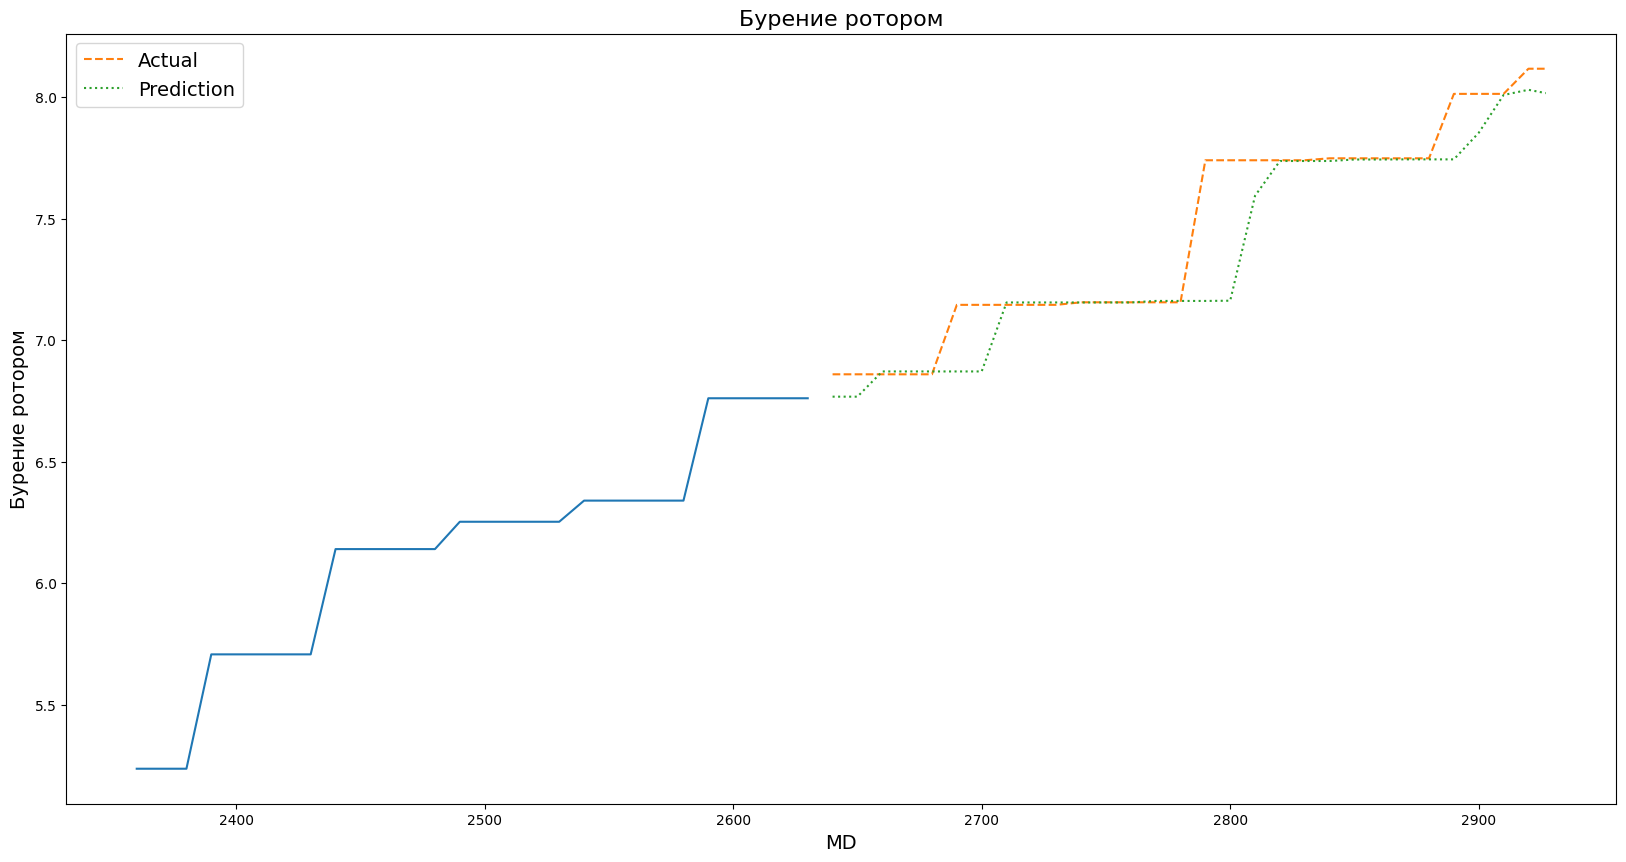

In [352]:
plt.figure(figsize=(20, 10))

plt.title('Бурение ротором', fontsize=16)

plt.plot(X_train["MD"], y_train['Бурение ротором'])

plt.plot(X_test["MD"], y_test['Бурение ротором'], label="Actual", linestyle='--')

plt.plot(X_test["MD"], predictions['Бурение ротором'], label="Prediction", linestyle=':')

plt.xlabel('MD', fontsize=14)
plt.ylabel('Бурение ротором', fontsize=14)
plt.legend(fontsize=14) 

plt.show()


In [353]:
y_test = y_test.reset_index().drop("index", axis=1)
mape = (abs(y_test - predictions) / (y_test+1e-8)).mean() * 100

print("MAPE Error in percents per column")
print(mape.to_frame())

MAPE Error in percents per column
                               0
Бурение ротором     1.216409e+00
Подъём              9.116643e+05
 Make-up Torque     2.240751e-02
Спуск               1.222163e+06
Момент свинчивания  2.240751e-02


['Бурение ротором', 'Подъём', ' Make-up Torque', 'Спуск', 'Момент свинчивания']


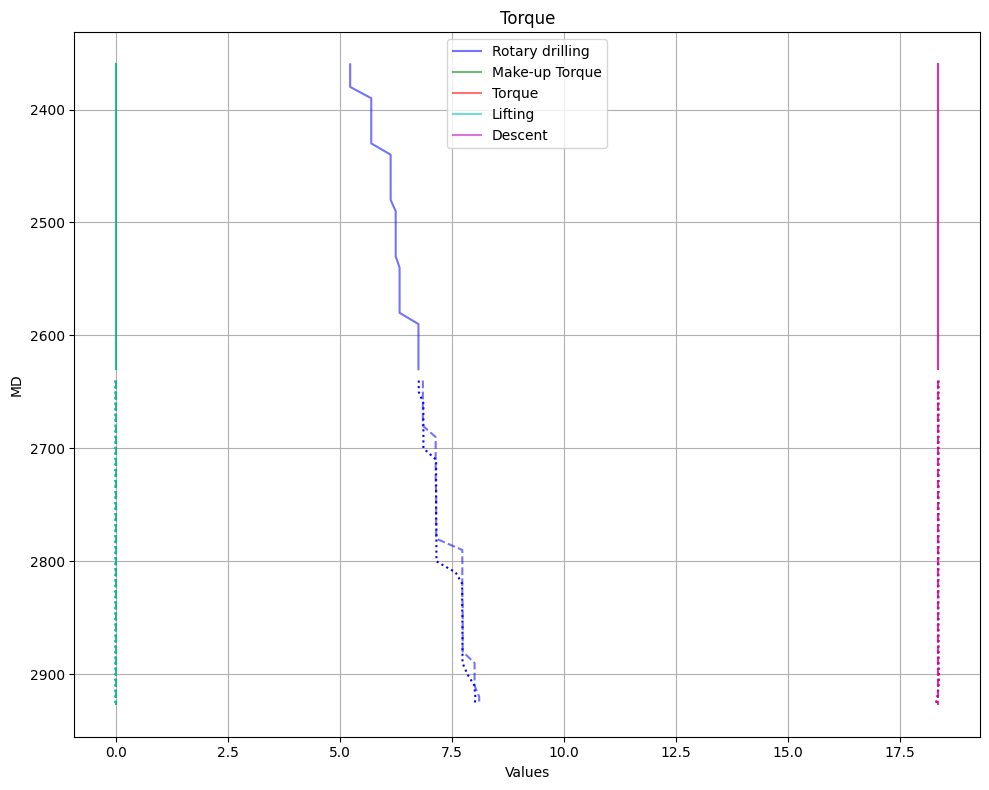

In [354]:
target_cols_eng = ['Rotary drilling', 'Make-up Torque', 'Torque', 'Lifting', 'Descent']

plt.figure(figsize=(10, 8))  # Set the figure size
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500']

for color, col_id in zip(color_list, range(len(target_cols))):
    col = target_cols[col_id]
    label = target_cols_eng[col_id]
    plt.plot( y_train[col], X_train["MD"], label=label, color=color, alpha=0.55)
    plt.plot( y_test[col], X_test["MD"], color=color, alpha=0.55, linestyle = '--')
    plt.plot( predictions[col], X_test["MD"], color=color, alpha=1.0, linestyle = ':')

print(target_cols)
# ['Бурение ротором', ' Make-up Torque', 'Момент свинчивания', 'Подъём', 'Спуск']

# Add labels and title
plt.xlabel('Values')
plt.ylabel('MD')
plt.title('Torque')

# Add legend
plt.legend()
plt.gca().invert_yaxis()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


## `Эффект натяжения`

In [355]:
Y_ves = pd.read_csv("../data/preprocessed/aktobe120/aktobe120_Y_effect_na.csv")
Y_ves = Y_ves.rename({"Глубина по стволу" : "MD"}, axis=1).drop("Глубина по вертикали", axis=1)
# Y_ves["MD"] = Y_ves["MD"].str.replace(",", "").astype(float)
Y_ves.head(5)

,MD,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Синусоидальный изгиб(все операции),Спиральный изгиб(с вращением),Спиральный изгиб(без вращения),Предел натяжения,Грузоподъёмность вышки
0,0.00,41.11,63.80,45.75,37.98,-24.83,-35.12,-70.24,128.96,225
1,9.03,40.96,63.50,45.54,37.82,-10.94,-15.47,-30.94,128.96,225
2,18.06,40.78,63.26,45.33,37.64,-2.01,-2.84,-5.68,128.96,225
3,27.09,40.58,63.04,45.13,37.44,-14.17,-20.04,-40.09,128.96,225
4,36.13,40.43,62.75,44.92,37.29,-0.92,-1.31,-2.61,128.96,225


In [356]:
target_cols = list(set(Y_ves.columns) - set(["MD"]))
Y_ves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   MD                                  344 non-null    float64
 1   Спуск                               344 non-null    float64
 2   Подъём                              344 non-null    float64
 3   Бурение ротором                     344 non-null    float64
 4   Бурение ГЗД                         344 non-null    float64
 5   Синусоидальный изгиб(все операции)  344 non-null    float64
 6   Спиральный изгиб(с вращением)       344 non-null    float64
 7   Спиральный изгиб(без вращения)      344 non-null    float64
 8   Предел натяжения                    344 non-null    float64
 9   Грузоподъёмность вышки              344 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 27.0 KB


In [357]:
X_ves = X[(X["MD"] >= Y_ves["MD"].min()) & (X["MD"] <= Y_ves["MD"].max())]
X_ves.head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
0,100.0,0.300,108.180,117.368,100.000,-0.082,0.249,5089454.418,9691423.939,0.090,0.01,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
1,110.0,0.411,92.123,127.367,109.999,-0.091,0.309,5089454.409,9691423.999,0.445,0.02,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
2,120.0,0.360,88.348,137.367,119.999,-0.092,0.377,5089454.408,9691424.067,0.171,0.04,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
3,130.0,0.273,93.810,147.367,129.999,-0.092,0.432,5089454.408,9691424.122,0.275,0.06,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
4,140.0,0.263,104.222,157.367,139.999,-0.100,0.478,5089454.400,9691424.168,0.149,0.07,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105


In [358]:
X_ves.rename(columns = {'Local N Coord':'Local_N_Coord', 'Local E Coord':'Local_E_Coord', 
                                            'Global N Coord':'Global_N_Coord', 'Global E Coord':'Global_E_Coord',
                                            'Incl.':'Incl',
                                            'Vertical Section':'Vertical_Section',
                                            'Azim.':'Azim',
                                            'Sub-Sea':'Sub_Sea',
                                            'Coefficient of Friction':'Coefficient_of_Friction',
                                            'Minimum Yield Stress':'Minimum_Yield_Stress'
                                            }, 
                                            inplace = True)

In [359]:
df = pd.merge_asof(X_ves, Y_ves, on="MD", direction="nearest")
df.head()

,MD,Incl,Azim,Sub_Sea,TVD,Local_N_Coord,Local_E_Coord,Global_N_Coord,Global_E_Coord,Dogleg,...,Minimum_Yield_Stress,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Синусоидальный изгиб(все операции),Спиральный изгиб(с вращением),Спиральный изгиб(без вращения),Предел натяжения,Грузоподъёмность вышки
0,100.0,0.300,108.180,117.368,100.000,-0.082,0.249,5089454.418,9691423.939,0.090,...,105,39.14,61.07,43.48,35.99,-3.22,-4.55,-9.10,128.96,225
1,110.0,0.411,92.123,127.367,109.999,-0.091,0.309,5089454.409,9691423.999,0.445,...,105,38.95,60.83,43.27,35.80,-11.18,-15.81,-31.62,128.96,225
2,120.0,0.360,88.348,137.367,119.999,-0.092,0.377,5089454.408,9691424.067,0.171,...,105,38.79,60.56,43.07,35.63,-7.21,-10.19,-20.39,128.96,225
3,130.0,0.273,93.810,147.367,129.999,-0.092,0.432,5089454.408,9691424.122,0.275,...,105,38.61,60.31,42.86,35.45,-3.97,-5.61,-11.23,128.96,225
4,140.0,0.263,104.222,157.367,139.999,-0.100,0.478,5089454.400,9691424.168,0.149,...,105,38.24,59.84,42.45,35.07,-4.48,-6.34,-12.67,128.96,225


In [360]:
y_full = df[target_cols]
X_full = df.drop(target_cols, axis=1).fillna(method="ffill")
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size=.5,shuffle=False)
X_train.shape, X_test.shape

/var/folders/rt/ht2w66yn71737qv5l2n9w4s00000gn/T/ipykernel_1932/3649872305.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_full = df.drop(target_cols, axis=1).fillna(method="ffill")


((169, 20), (170, 20))

In [361]:
# Apply feature engineering to both training and test data
X_test = add_features(X_test)

# Load the Keras neural network model
nn_model = tf.keras.models.load_model(f'nn_model_effect_na.h5')

# Load the XGBoost model
xgb_model = joblib.load(f'xgb_model_effect_na.pkl')

# Load the scalers
x_scaler = joblib.load(f'x_scaler_effect_na.pkl')
y_scaler = joblib.load(f'y_scaler_effect_na.pkl')


# Scale the test data
X_test_scaled = x_scaler.transform(X_test)

# Make predictions using the neural network
nn_predictions = nn_model.predict(X_test_scaled)

# Combine predictions with original input dataset for XGBoost
xgb_input = np.concatenate((X_test_scaled, nn_predictions), axis=1)

# Make predictions using XGBoost
xgb_predictions = xgb_model.predict(xgb_input)

# Inverse transform the predictions to original scale
predictions = pd.DataFrame(y_scaler.inverse_transform(xgb_predictions), columns=y_test.columns)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [362]:
predictions

,Грузоподъёмность вышки,Бурение ротором,Спиральный изгиб(без вращения),Подъём,Синусоидальный изгиб(все операции),Спуск,Бурение ГЗД,Спиральный изгиб(с вращением),Предел натяжения
0,225.0,6.102692,-19.393787,18.142891,-6.852988,4.859511,1.209425,-9.695026,127.427299
1,225.0,6.032481,-21.057865,18.126846,-7.441027,4.783532,1.149675,-10.527927,127.252625
2,225.0,5.955132,-19.487179,18.035778,-6.886389,4.745584,1.114726,-9.741482,127.416061
3,225.0,5.805997,-16.215710,17.870283,-5.730044,4.602674,0.971484,-8.105976,127.415947
4,225.0,5.401643,-10.188198,17.399925,-3.599749,4.199224,0.556350,-5.091980,127.547562
...,...,...,...,...,...,...,...,...,...
165,225.0,-6.073047,-46.045589,0.833656,-16.282888,-0.861170,-3.315478,-23.024372,127.082397
166,225.0,-6.010916,-40.839531,0.586673,-14.443666,-0.578626,-3.119770,-20.423847,128.502975
167,225.0,-6.078742,-41.761822,0.714467,-14.769610,-0.644803,-3.094732,-20.883915,126.511734
168,225.0,-6.162859,-48.195621,0.698699,-17.043320,-0.731227,-3.148648,-24.101229,126.733940


In [365]:
y_test

,Грузоподъёмность вышки,Бурение ротором,Спиральный изгиб(без вращения),Подъём,Синусоидальный изгиб(все операции),Спуск,Бурение ГЗД,Спиральный изгиб(с вращением),Предел натяжения
169,225,6.20,-11.47,18.34,-4.05,4.95,1.32,-5.73,127.32
170,225,6.01,-22.64,18.13,-8.00,4.76,1.14,-11.32,127.32
171,225,5.81,-14.07,17.91,-4.97,4.57,0.95,-7.03,127.32
172,225,5.61,-14.56,17.69,-5.15,4.38,0.76,-7.28,127.32
173,225,5.42,-5.29,17.47,-1.87,4.19,0.57,-2.64,127.32
...,...,...,...,...,...,...,...,...,...
334,225,-6.00,-42.75,0.63,-15.12,-0.63,-3.13,-21.38,127.32
335,225,-6.00,-213.26,0.57,-75.40,-0.57,-3.07,-106.63,627.08
336,225,-6.00,-183.88,0.34,-65.02,-0.34,-2.84,-91.94,627.08
337,225,-6.00,-151.69,0.12,-53.63,-0.12,-2.62,-75.85,669.24


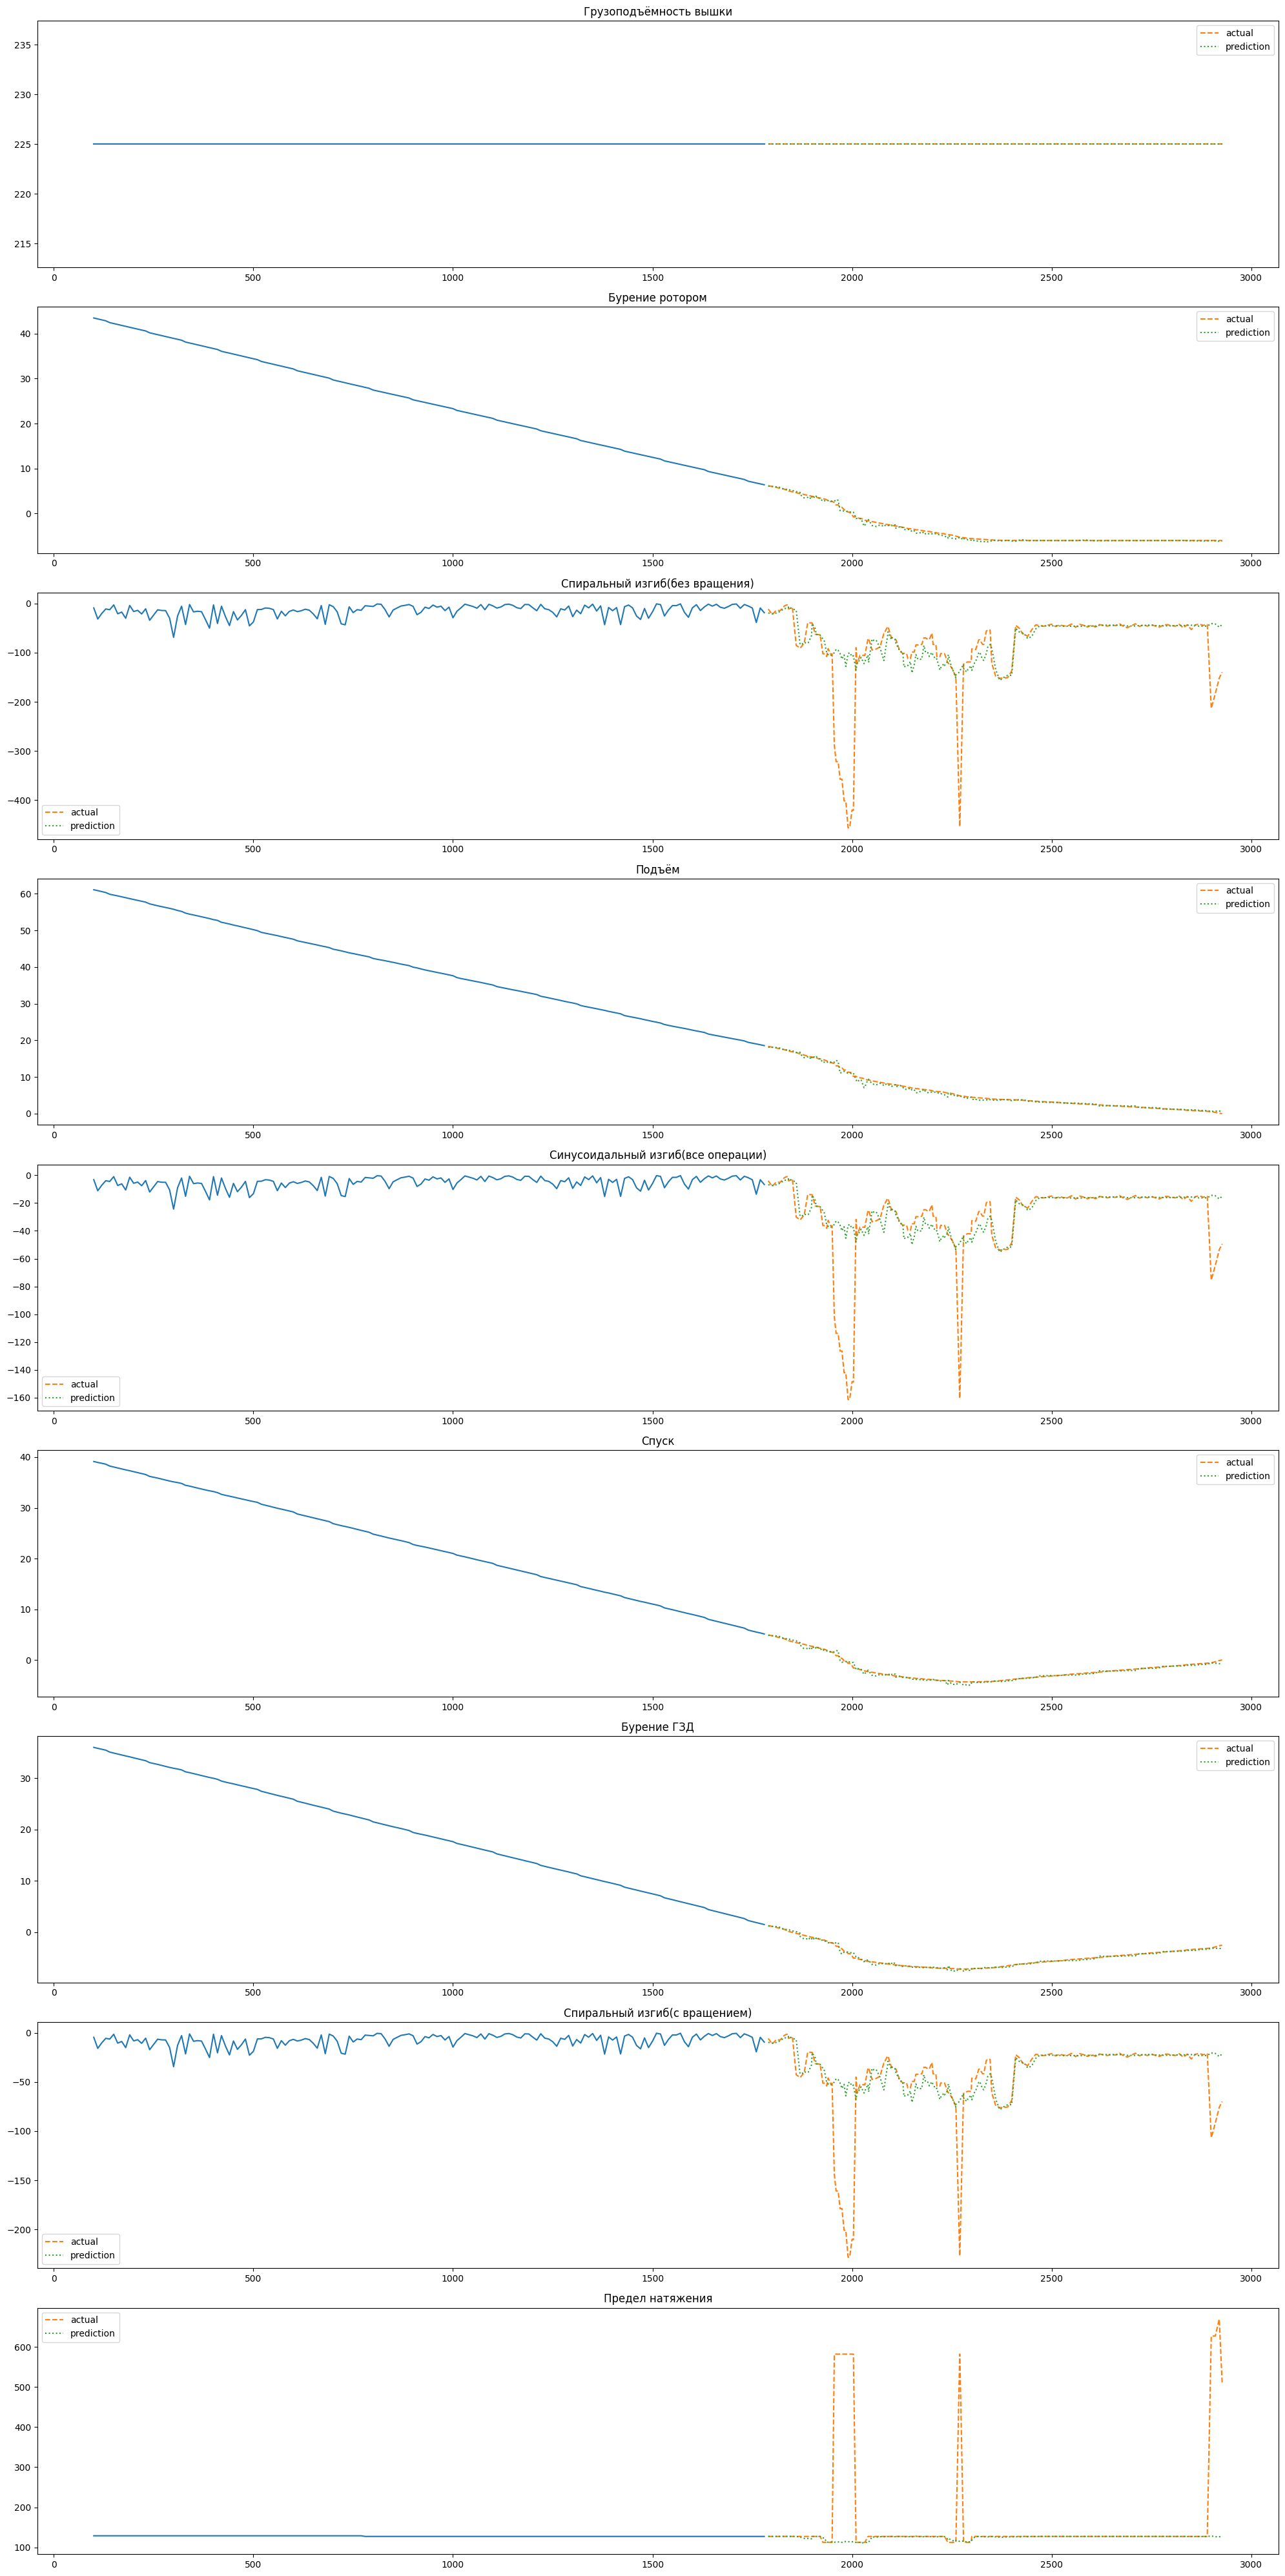

In [366]:
fig, ax = plt.subplots(len(target_cols), figsize=(20, 40))
for i, col in enumerate(target_cols):
    ax[i].set_title(col)
    ax[i].plot(X_train["MD"], y_train[col])
    ax[i].plot(X_test["MD"], y_test[col], label="actual",  linestyle='--')
    ax[i].plot(X_test["MD"], predictions[col], label="prediction", linestyle=':')
    ax[i].legend() 
plt.tight_layout()
plt.show()

In [367]:
y_test = y_test.reset_index().drop("index", axis=1)
mape = (abs(y_test - predictions) / (abs(y_test)+1e-8)).mean() * 100

print("MAPE Error in percents per column")
print(mape.to_frame())

MAPE Error in percents per column
                                               0
Грузоподъёмность вышки              0.000000e+00
Бурение ротором                     1.164156e+01
Спиральный изгиб(без вращения)      2.713339e+01
Подъём                              4.157290e+07
Синусоидальный изгиб(все операции)  2.714926e+01
Спуск                               3.969952e+07
Бурение ГЗД                         2.838521e+01
Спиральный изгиб(с вращением)       2.713736e+01
Предел натяжения                    8.900069e+00


['Грузоподъёмность вышки', 'Бурение ротором', 'Спиральный изгиб(без вращения)', 'Подъём', 'Синусоидальный изгиб(все операции)', 'Спуск', 'Бурение ГЗД', 'Спиральный изгиб(с вращением)', 'Предел натяжения']


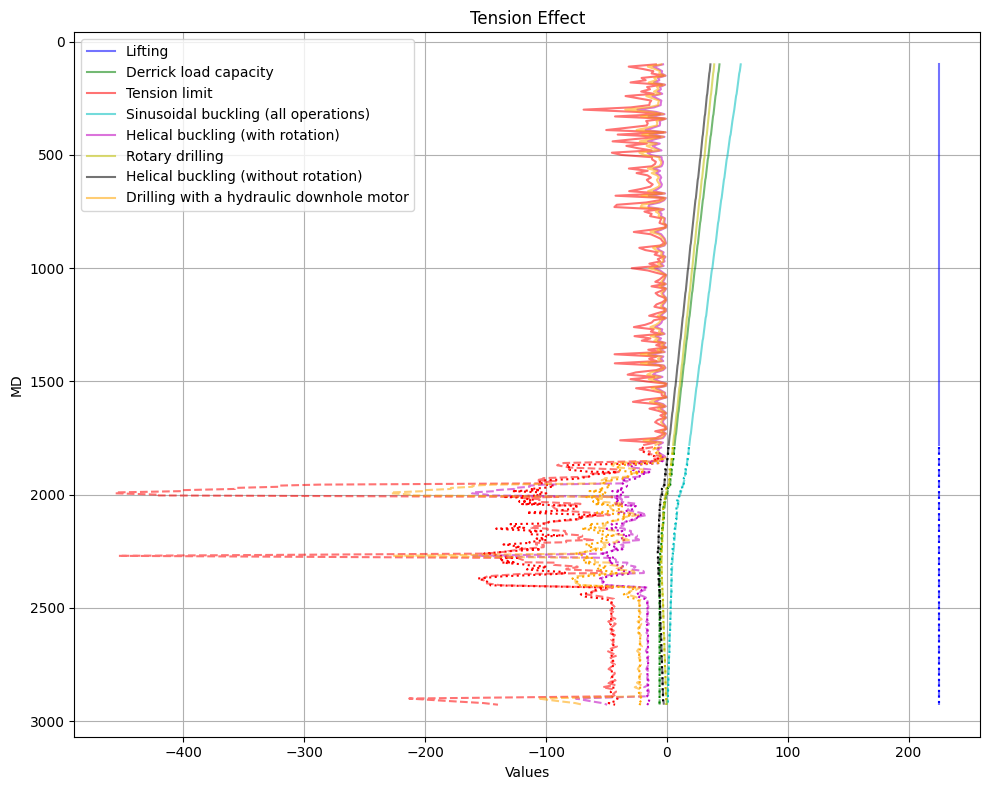

In [368]:
# Перевод target_cols на английский
target_cols_eng = ['Lifting', 'Derrick load capacity', 'Tension limit', 'Sinusoidal buckling (all operations)', 
                   'Helical buckling (with rotation)', 'Rotary drilling', 'Helical buckling (without rotation)', 
                   'Drilling with a hydraulic downhole motor', 'Descent']

plt.figure(figsize=(10, 8))  # Set the figure size
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500']

for color, col_id in zip(color_list, range(len(target_cols))):
    col = target_cols[col_id]
    label = target_cols_eng[col_id]
    plt.plot(y_train[col], X_train["MD"], label=label, color=color, alpha=0.55)
    plt.plot(y_test[col], X_test["MD"], color=color, alpha=0.55, linestyle = '--')
    plt.plot(predictions[col], X_test["MD"], color=color, alpha=1.0, linestyle = ':')

print(target_cols)
# ['Подъём', 'Грузоподъёмность вышки', 'Предел натяжения', 'Синусоидальный изгиб(все операции)', 
# 'Спиральный изгиб(с вращением)', 'Бурение ротором', 'Спиральный изгиб(без вращения)', 
# 'Бурение ГЗД', 'Спуск']

# Add labels and title
plt.xlabel('Values')
plt.ylabel('MD')
plt.title('Tension Effect')

# Add legend
plt.legend()
plt.gca().invert_yaxis()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


## `Минимальный вес на долоте`

In [369]:
Y_ves = pd.read_csv("../data/preprocessed/aktobe120/aktobe120_Y_min_ves.csv")
Y_ves = Y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1)
# Y_ves["MD"] = Y_ves["MD"].str.replace(",", "").astype(float)
Y_ves.head(5)

,MD,Мин. вес на долоте до синусоидального изгиба (бурение ротором),Мин. вес на долоте до спирального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до спирального изгиба (бурение ГЗД)
0,2359,8.55,9.32,4.71,5.56
1,2409,7.31,7.57,3.10,3.86
2,2459,7.12,7.32,2.72,3.29
3,2509,7.49,7.72,2.61,3.26
4,2559,8.98,9.33,3.46,4.48


In [370]:
target_cols = list(set(Y_ves.columns) - set(["MD"]))
Y_ves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 5 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   MD                                                              13 non-null     int64  
 1   Мин. вес на долоте до синусоидального изгиба (бурение ротором)  13 non-null     float64
 2   Мин. вес на долоте до спирального изгиба (бурение ротором)      13 non-null     float64
 3   Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)      13 non-null     float64
 4   Мин. вес на долоте до спирального изгиба (бурение ГЗД)          13 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 648.0 bytes


In [371]:
X_ves = X[(X["MD"] >= Y_ves["MD"].min()) & (X["MD"] <= Y_ves["MD"].max())]
X_ves.head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
279,2360.0,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,282.94,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
280,2370.0,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,292.79,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
281,2380.0,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,302.67,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
282,2390.0,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,312.60,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
283,2400.0,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,322.55,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105


In [372]:
Y_ves["MD"] = Y_ves["MD"].astype(int)
X_ves["MD"] = X_ves["MD"].astype(int)

df = pd.merge_asof(X_ves, Y_ves, on="MD", direction="nearest")
df.head()

/var/folders/rt/ht2w66yn71737qv5l2n9w4s00000gn/T/ipykernel_1932/1737649771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ves["MD"] = X_ves["MD"].astype(int)


,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,...,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress,Мин. вес на долоте до синусоидального изгиба (бурение ротором),Мин. вес на долоте до спирального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до спирального изгиба (бурение ГЗД)
0,2360,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,...,0.469,119.86,53.98,25.12,0.3,105,8.55,9.32,4.71,5.56
1,2370,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,...,0.469,119.86,53.98,25.12,0.3,105,8.55,9.32,4.71,5.56
2,2380,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,...,0.469,119.86,53.98,25.12,0.3,105,8.55,9.32,4.71,5.56
3,2390,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,...,0.469,119.86,53.98,25.12,0.3,105,7.31,7.57,3.10,3.86
4,2400,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,...,0.469,119.86,53.98,25.12,0.3,105,7.31,7.57,3.10,3.86


In [373]:
df.rename(columns = {'Local N Coord':'Local_N_Coord', 'Local E Coord':'Local_E_Coord', 
                                            'Global N Coord':'Global_N_Coord', 'Global E Coord':'Global_E_Coord',
                                            'Incl.':'Incl',
                                            'Vertical Section':'Vertical_Section',
                                            'Azim.':'Azim',
                                            'Sub-Sea':'Sub_Sea',
                                            'Coefficient of Friction':'Coefficient_of_Friction',
                                            'Minimum Yield Stress':'Minimum_Yield_Stress'
                                            }, 
                                            inplace = True)

In [374]:
y_full = df[target_cols]
X_full = df.drop(target_cols, axis=1).fillna(method="ffill")
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size= 0.5,shuffle=False)
X_train.shape, X_test.shape

/var/folders/rt/ht2w66yn71737qv5l2n9w4s00000gn/T/ipykernel_1932/1821649262.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_full = df.drop(target_cols, axis=1).fillna(method="ffill")


((30, 20), (30, 20))

In [375]:
# Apply feature engineering to both training and test data
X_test = add_features(X_test)

# Load the Keras neural network model
nn_model = tf.keras.models.load_model(f'nn_model_min_ves.h5')

# Load the XGBoost model
xgb_model = joblib.load(f'xgb_model_min_ves.pkl')

# Load the scalers
x_scaler = joblib.load(f'x_scaler_min_ves.pkl')
y_scaler = joblib.load(f'y_scaler_min_ves.pkl')


# Scale the test data
X_test_scaled = x_scaler.transform(X_test)

# Make predictions using the neural network
nn_predictions = nn_model.predict(X_test_scaled)

# Combine predictions with original input dataset for XGBoost
xgb_input = np.concatenate((X_test_scaled, nn_predictions), axis=1)

# Make predictions using XGBoost
xgb_predictions = xgb_model.predict(xgb_input)

# Inverse transform the predictions to original scale
predictions = pd.DataFrame(y_scaler.inverse_transform(xgb_predictions), columns=y_test.columns)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [376]:
predictions

,Мин. вес на долоте до спирального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до синусоидального изгиба (бурение ротором),Мин. вес на долоте до спирального изгиба (бурение ГЗД)
0,8.979056,2.854374,8.744157,3.533993
1,8.972474,2.861208,8.736124,3.538525
2,8.895866,2.549725,8.587960,3.399093
3,8.895866,2.549725,8.587960,3.399093
4,8.906923,2.544152,8.585460,3.421663
5,8.877087,2.456151,8.568893,3.333366
6,8.867021,2.337033,8.582232,3.160845
7,8.783082,2.178632,8.550297,2.859737
8,8.763172,2.241229,8.574281,2.838938
9,8.888446,2.127402,8.687374,2.745698


In [379]:
y_test

,Мин. вес на долоте до спирального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до синусоидального изгиба (бурение ротором),Мин. вес на долоте до спирального изгиба (бурение ГЗД)
30,9.15,2.66,8.80,3.67
31,9.15,2.66,8.80,3.67
32,9.15,2.66,8.80,3.67
33,9.15,2.66,8.80,3.67
34,9.15,2.66,8.80,3.67
35,8.97,2.25,8.72,2.98
36,8.97,2.25,8.72,2.98
37,8.97,2.25,8.72,2.98
38,8.97,2.25,8.72,2.98
39,8.97,2.25,8.72,2.98


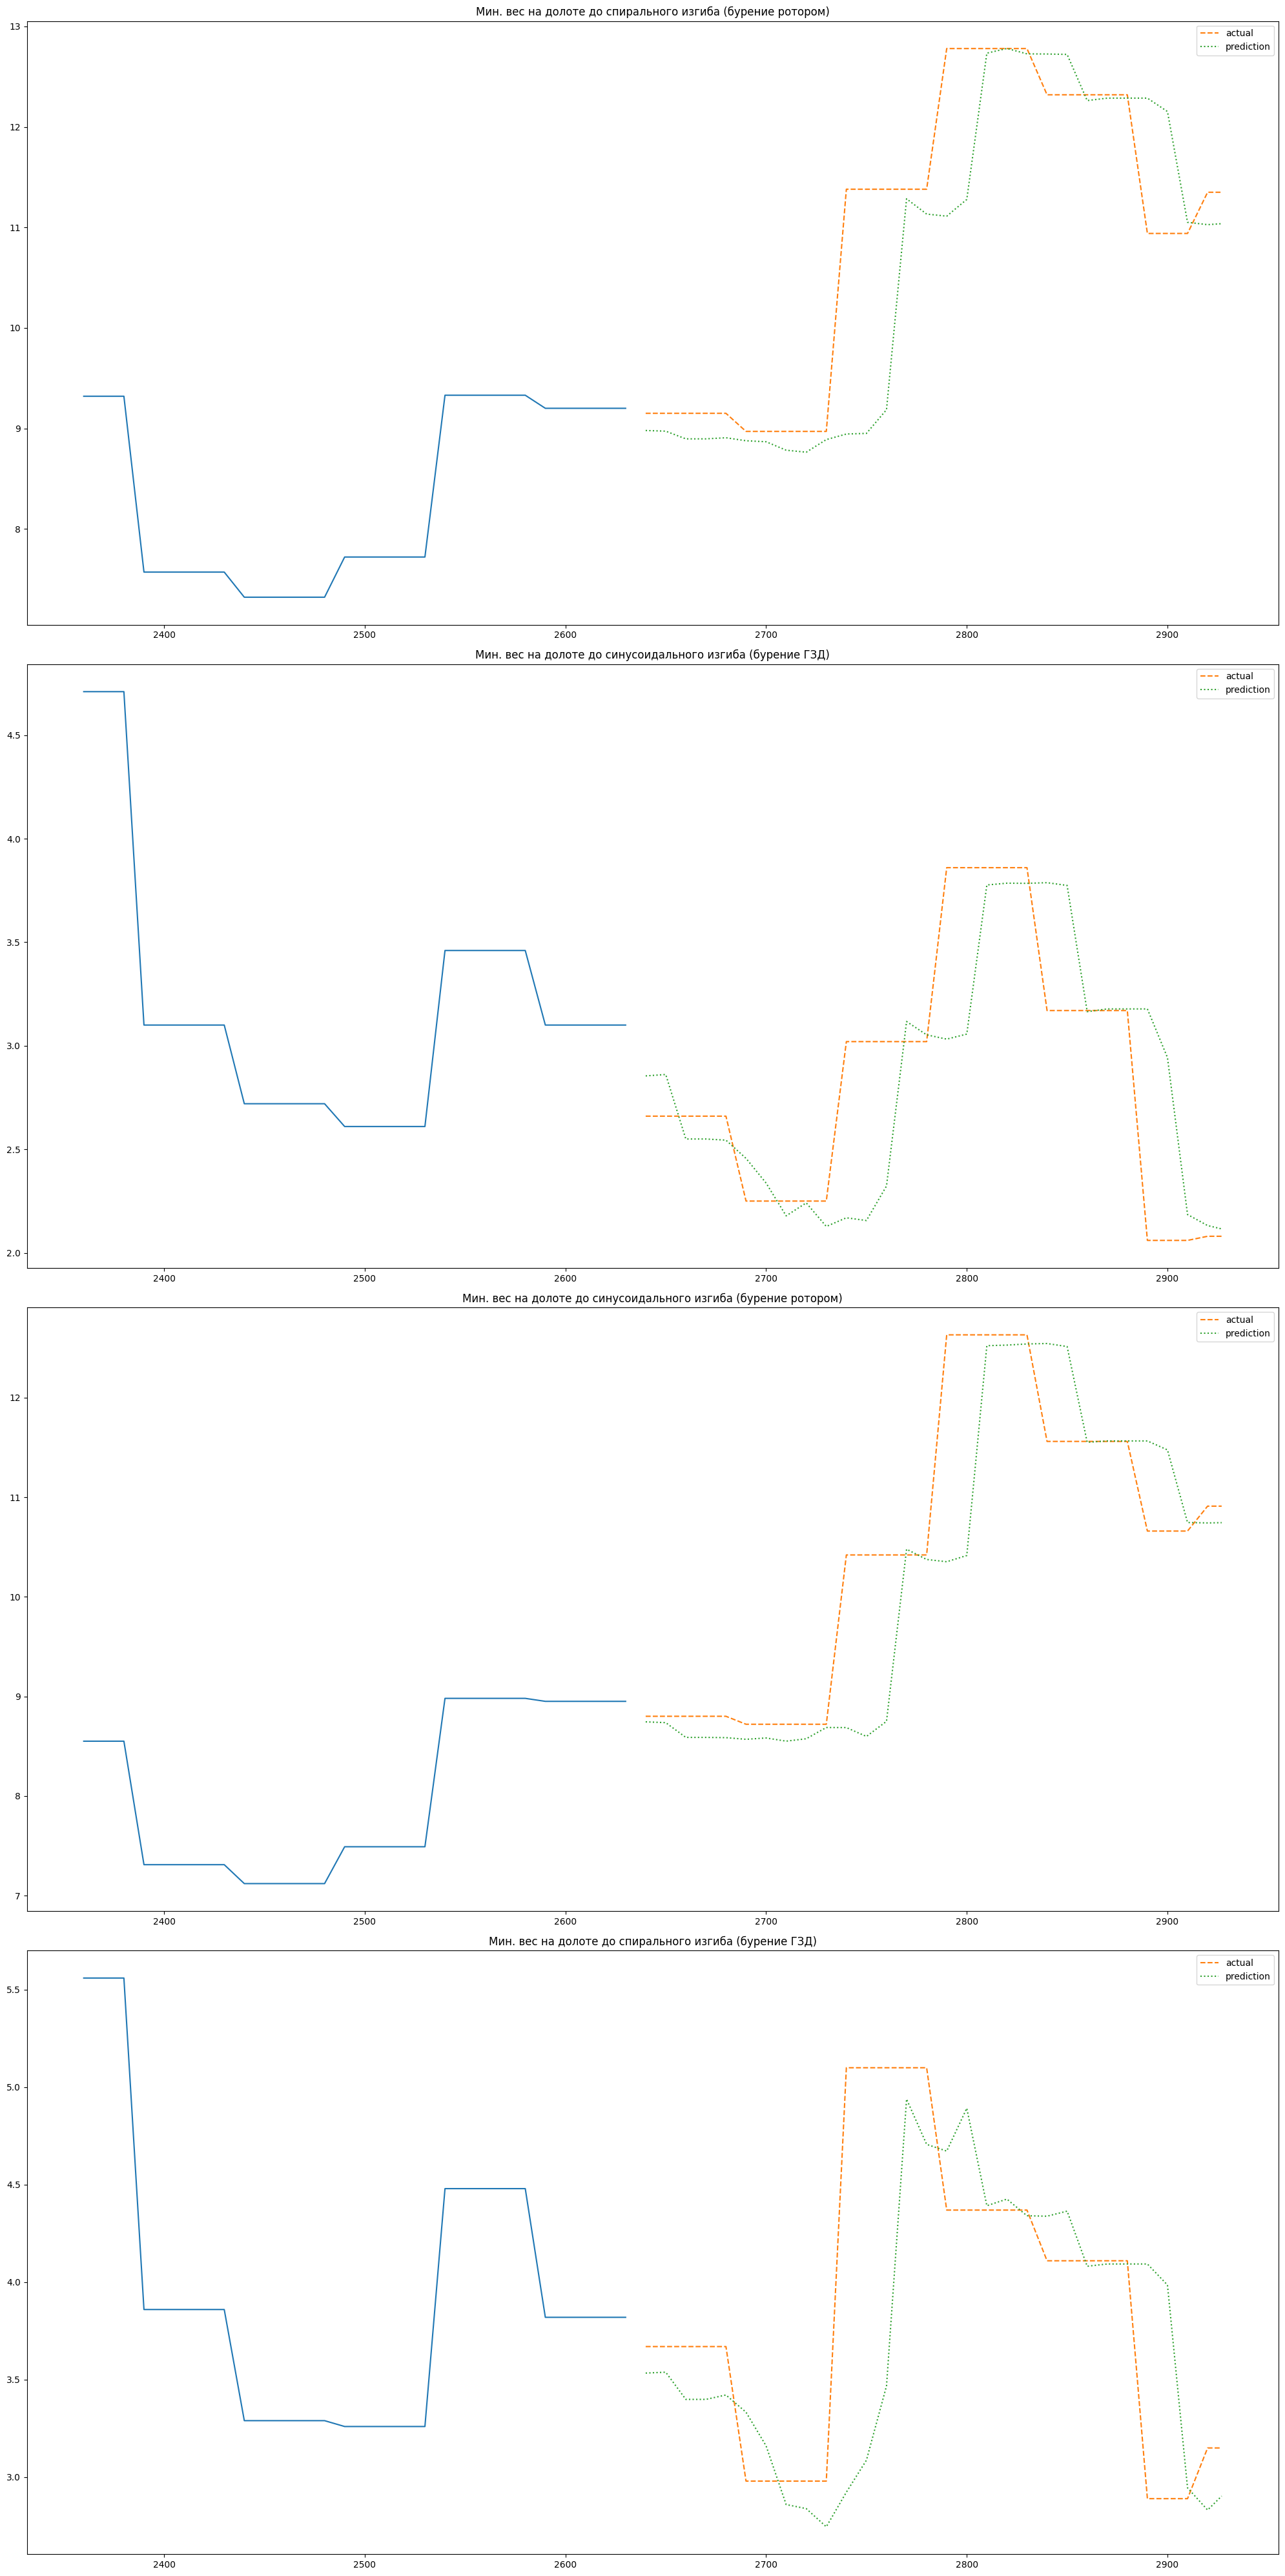

In [380]:
fig, ax = plt.subplots(len(target_cols), figsize=(20, 40))
for i, col in enumerate(target_cols):
    ax[i].set_title(col)
    ax[i].plot(X_train["MD"], y_train[col])
    ax[i].plot(X_test["MD"], y_test[col], label="actual",  linestyle='--')
    ax[i].plot(X_test["MD"], predictions[col], label="prediction", linestyle=':')
    ax[i].legend() 
plt.tight_layout()
plt.show()

In [381]:
y_test = y_test.reset_index().drop("index", axis=1)
mape = (abs(y_test - predictions) / (abs(y_test)+1e-8)).mean() * 100

print("MAPE Error in percents per column")
print(mape.to_frame())

MAPE Error in percents per column
                                                            0
Мин. вес на долоте до спирального изгиба (бурен...   4.923264
Мин. вес на долоте до синусоидального изгиба (б...  10.955158
Мин. вес на долоте до синусоидального изгиба (б...   4.731828
Мин. вес на долоте до спирального изгиба (бурен...  10.746483


['Мин. вес на долоте до спирального изгиба (бурение ротором)', 'Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)', 'Мин. вес на долоте до синусоидального изгиба (бурение ротором)', 'Мин. вес на долоте до спирального изгиба (бурение ГЗД)']


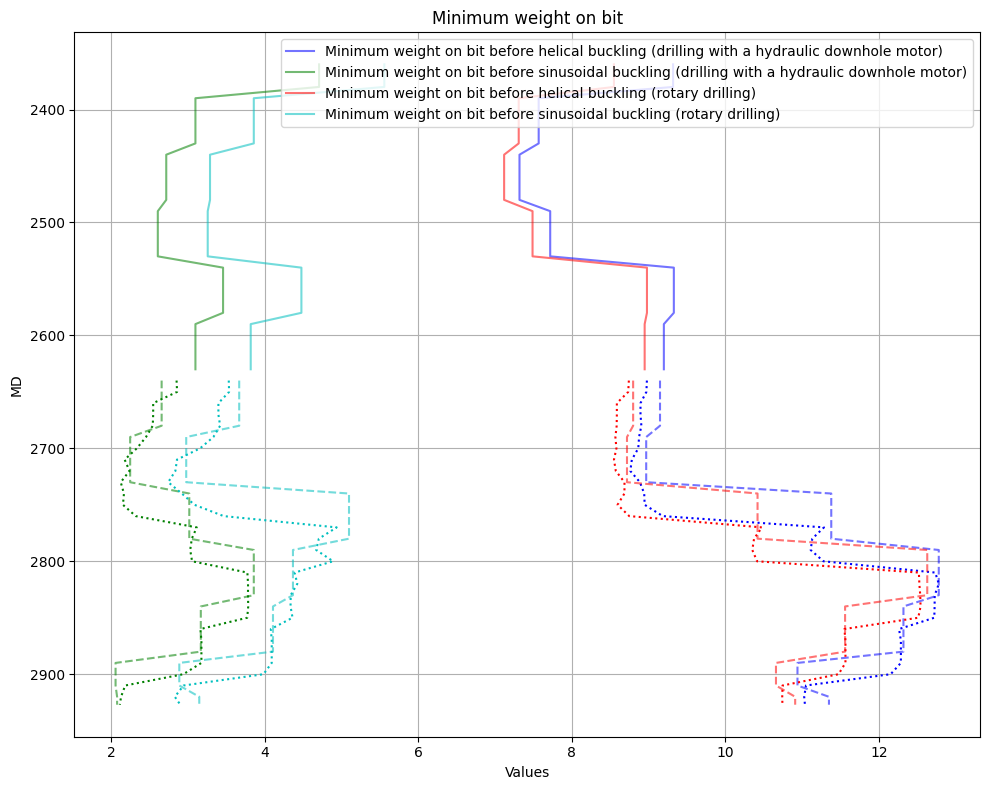

In [382]:
# Перевод target_cols на английский
target_cols_eng = ['Minimum weight on bit before helical buckling (drilling with a hydraulic downhole motor)', 
                   'Minimum weight on bit before sinusoidal buckling (drilling with a hydraulic downhole motor)', 
                   'Minimum weight on bit before helical buckling (rotary drilling)', 
                   'Minimum weight on bit before sinusoidal buckling (rotary drilling)']

plt.figure(figsize=(10, 8))  # Set the figure size
color_list = ['b', 'g', 'r', 'c']

for color, col_id in zip(color_list, range(len(target_cols))):
    col = target_cols[col_id]
    label = target_cols_eng[col_id]
    plt.plot(y_train[col], X_train["MD"], label=label, color=color, alpha=0.55)
    plt.plot(y_test[col], X_test["MD"], color=color, alpha=0.55, linestyle = '--')
    plt.plot(predictions[col], X_test["MD"], color=color, alpha=1.0, linestyle = ':')

print(target_cols)
# ['Мин. вес на долоте до спирального изгиба (бурение ГЗД)', 
#  'Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)', 
#  'Мин. вес на долоте до спирального изгиба (бурение ротором)', 
#  'Мин. вес на долоте до синусоидального изгиба (бурение ротором)']

# Add labels and title
plt.xlabel('Values')
plt.ylabel('MD')
plt.title('Minimum weight on bit')

# Add legend
plt.legend()
plt.gca().invert_yaxis()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()
